# **How do types of crime and demographic and economic factors in different community areas influence arrest rates in Chicago?**

# Project 1

## 1.1 Introduction

Crime is a complex and multifaceted issue that has significant implications for public safety and community well-being. In general, Crime could be divided into two types, violent and non-violent crime; furthermore, crimes like "Homicide", "Assault", and "Robbery" are considered violent, while crimes like "Theft" and "Property damage" are non-violent. Ousey (2000) discusses that declining economic status increases poverty rates and population movements like new immigrants, and leads to rising crime rates. The city of Chicago, like many urban centers, experiences a diverse range of criminal activities. Therefore, Chicago has been grappling with crime-related concerns, and understanding the factors influencing arrest rates can offer valuable insights into effective law enforcement strategies and community safety. This dataset reference is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system and hosted in Google BigQuery, which contains incidents of crime except murders that occurred in the city of Chicago from 2001 to 2024.

Braga et al. (2012) suggest that robbery incidents were highly concentrated in a small number of street units and that these units exhibited different trends over time depending on the type of robbery (street, commercial, or other). Hence, I am wondering whether other types of crime would likely take place in only certain community areas, and what factors cause it. Moreover, Wilson (1987) discusses that disadvantaged communities experience disproportionately high levels of unemployment, inadequate educational opportunities, and limited access to essential resources, which fosters an environment conducive to crime. Therefore, I am going to start with per capita income to observe the relationship between the number of crimes and the arrest rate caused by economic factors. 

In addition, racial disparity is a topic that has been concerned and discussed all the time. Despite controlling for various factors, Black young adults are found to be arrested seven times more often than their White counterparts (Schleiden et al., 2020). I will also research race distribution to see how this is relevant to my research question. Erbe (1975) mentions that affluent Black individuals experience less isolation from low-income Black individuals compared to the level of isolation observed among high-income White individuals and low-income White individuals. That might explain why low-income areas are predominantly black. In this project, I am going to observe whether the crime rate changes from year to year, in the meanwhile, more detailed observations make sense, such as whether changes in temperature over the four seasons of the year affect criminal activity and arrest rates. Hou et al. (2023) suggest that high temperatures have a positive effect on increasing urban crime risk.

This project seeks to analyze the relationship between different crime types and areas of Chicago and the arrest rate from 2002 to 2023. Also, I will explore the influence of some economic factors on different crime types in various regions, contributing to our understanding of the nuanced factors affecting arrest rates in Chicago. Throughout my analysis, I will employ statistical tools, including histograms, box plots, and line charts, to visually represent the relationships between crime types, time, locations, and arrest rates. These visualizations will provide valuable insights into patterns and trends within the dataset.

The outcome of this project is arrest rate and there are three independent variables, crime types, time and location. For the first variable ($X_1$), there are 35 crime types in the dataset. The second variable ($X_2$) is the population of the 77 community areas. The last variable ($X_3$) is the time from 2002 to 2023. The type of crime in a given area can significantly affect law enforcement strategies, community safety perceptions, and arrest rates. In addition, factors such as socioeconomic conditions, population density, and community policing strategies may contribute to differences in arrest rates across locations. Hence, after this research, I could understand how different crime types and locations relate to arrest rates, and so learn more about Chicago's crime dynamics. However, it is essential to acknowledge the limitations inherent in this study, such as potential data constraints and external factors influencing crime dynamics.

## 1.2 Data Cleaning and Loading

Before summarising, I need to clean our original dataset first. In this section, I will drop some columns that are useless to my research, such as 'ICUR', 'Domestic', 'Beat', and 'Ward'. Also, there are some incidents that do not keep detailed records, so we need to clean those data to get a more complete dataset, called 'chicago_crime_clean'. To keep the data clean, we change the data of 'District' and 'Community Area' from float to integer.

In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point

In [119]:
relative_path = os.path.join('..', 'Data', 'Chicago_Crime.csv')
abs_path = os.path.abspath(relative_path)

# Read the CSV file
chicago_crime = pd.read_csv(abs_path)

In [4]:
chicago_crime.shape

(7983700, 22)

In [5]:
chicago_crime.isnull().any(axis=0)

ID                      False
Case Number             False
Date                    False
Block                   False
IUCR                    False
Primary Type            False
Description             False
Location Description     True
Arrest                  False
Domestic                False
Beat                    False
District                 True
Ward                     True
Community Area           True
FBI Code                False
X Coordinate             True
Y Coordinate             True
Year                    False
Updated On              False
Latitude                 True
Longitude                True
Location                 True
dtype: bool

In this dataset, there are 7983700 rows and 22 columns, for those columns, the community area contains missing data, so I need to drop these data to make accurate observations.

In [120]:
# Drop missing value
chicago_crime_clean = chicago_crime.dropna()
# Drop community area missing value
chicago_crime_clean = chicago_crime_clean[chicago_crime_clean['Community Area'] !=0]
# Drop useless columns
chicago_crime_clean = chicago_crime_clean.drop(['IUCR','Location Description','Domestic','Beat',
                                                'Ward','Block','FBI Code','X Coordinate','Y Coordinate',
                                                'Updated On','Description','District'], axis=1)

After dropping missing values we found that the number of incidents in the years 2001 and 2024 is much less than in other years, especially for the year 2024, there are at most two months' data in the dataset. In this research, I will focus on the annual change in arrest rates. Therefore, I am going to delete these two years.

In [121]:
# Drop years 2001 and 2024
chicago_crime_clean = chicago_crime_clean[(chicago_crime_clean['Year'] != 2001) & (chicago_crime_clean['Year'] != 2024)]
# Change ' Community Area' data into int
chicago_crime_clean['Community Area'] = chicago_crime_clean['Community Area'].astype(int)
# Drop duplicates to keep unique rows
type_mapping = {'CRIM SEXUAL ASSAULT':'CRIMINAL SEXUAL ASSAULT', 'NON - CRIMINAL':'NON-CRIMINAL'}
chicago_crime_clean['Primary Type'] = chicago_crime_clean['Primary Type'].replace(type_mapping)
chicago_crime_clean = chicago_crime_clean.drop_duplicates()

In [7]:
chicago_crime_clean.shape

(7268092, 11)

After cleaning data, there are 7,268,092 rows and 11 columns left.

## 1.3 Summary Statistics Tables and Plots

### $X_1$: Crime Types

In [122]:
# Create a pivot table to count the number of 'True' and 'False' in each primary type
crime_arrest = chicago_crime_clean.pivot_table(index='Primary Type', columns='Arrest', aggfunc='size', fill_value=0)
# Rename culumns to clarify
crime_arrest.columns = ['Arrested (False)', 'Arrested (True)']
crime_arrest['Percent_Arrested (True)'] = (crime_arrest['Arrested (True)'] / (crime_arrest['Arrested (False)'] + 
                                                                              crime_arrest['Arrested (True)'])) * 100
crime_arrest = crime_arrest.reset_index()
crime_arrest.describe()

,Arrested (False),Arrested (True),Percent_Arrested (True)
count,3.300000e+01,33.000000,33.000000
mean,1.640142e+05,56231.030303,41.441135
std,3.246437e+05,125913.303927,36.313729
min,3.000000e+00,2.000000,5.653641
25%,1.670000e+02,623.000000,11.912738
50%,6.564000e+03,12790.000000,20.752443
75%,2.508970e+05,54229.000000,72.812999
max,1.374957e+06,668226.000000,99.549286


The statistical table above shows that for all of 33 types of crimes, the highest arrest rate is about 99.6%, and the lowest arrest rate is about 5.7%. Also, the average arrest rate is 41.4% approximately, which means more than half of the suspects are not arrested. I will plot graphs to show each primary type's arrest rates later.

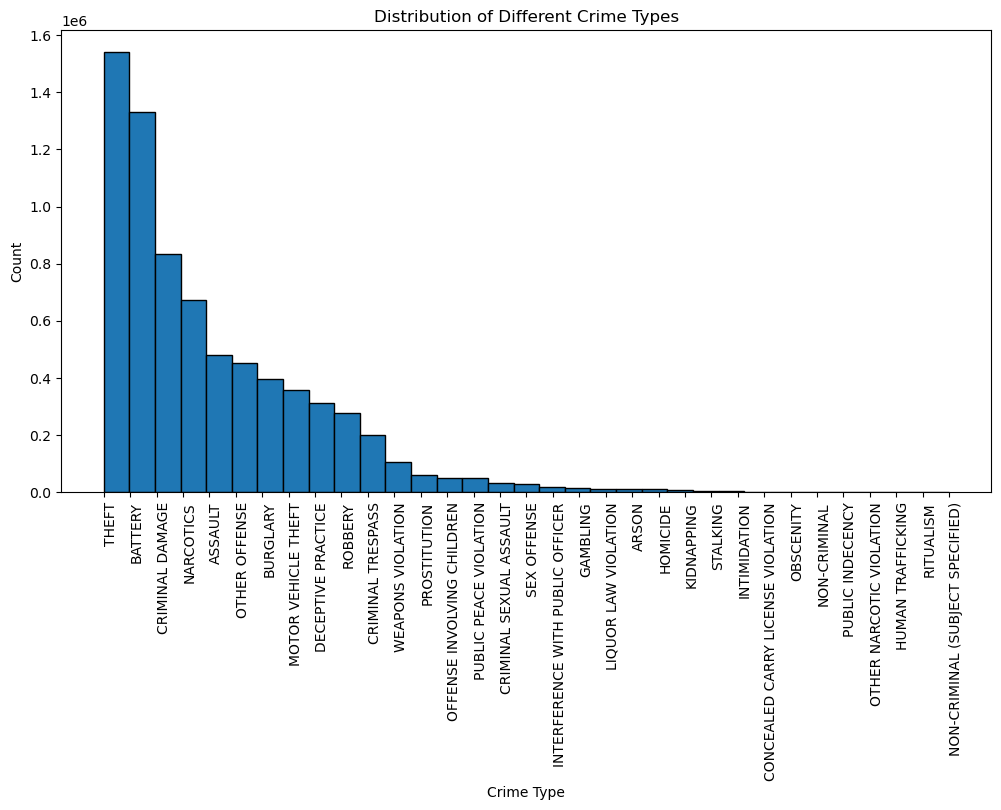

In [77]:
crime_type_counts = chicago_crime_clean['Primary Type'].value_counts()
crime_type_counts_sorted = crime_type_counts.sort_values(ascending = False)
sorted_data = chicago_crime_clean['Primary Type'].map(lambda x: crime_type_counts_sorted.index.get_loc(x))
# Create a histogram
plt.figure(figsize=(12,6))
plt.hist(sorted_data, bins=len(crime_type_counts_sorted), edgecolor='black')
plt.title('Distribution of Different Crime Types')
plt.xlabel('Crime Type')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='left', ticks=range(len(crime_type_counts_sorted.index)), labels=crime_type_counts_sorted.index)
plt.show()

The histogram is the distribution of crime types' counts, some types having fewer quantities, but I cannot give up any crime types' data since I am going to analyze how crime types influence arrest rates, also these incidents will keep happening in our lives even though the amount that occurs is small. The graph gives us information that the number of crime types of theft and battery is the highest.

In [78]:
crime_arrest.set_index('Primary Type', inplace = True)
print(crime_arrest.loc[crime_arrest['Percent_Arrested (True)'].idxmax()])
print(crime_arrest.loc[crime_arrest['Percent_Arrested (True)'].idxmin()])
print(crime_arrest.describe())

Arrested (False)             277.000000
Arrested (True)            61181.000000
Percent_Arrested (True)       99.549286
Name: PROSTITUTION, dtype: float64
Arrested (False)           373154.000000
Arrested (True)             22361.000000
Percent_Arrested (True)         5.653641
Name: BURGLARY, dtype: float64
       Arrested (False)  Arrested (True)  Percent_Arrested (True)
count      3.300000e+01        33.000000                33.000000
mean       1.640142e+05     56231.030303                41.441135
std        3.246437e+05    125913.303927                36.313729
min        3.000000e+00         2.000000                 5.653641
25%        1.670000e+02       623.000000                11.912738
50%        6.564000e+03     12790.000000                20.752443
75%        2.508970e+05     54229.000000                72.812999
max        1.374957e+06    668226.000000                99.549286


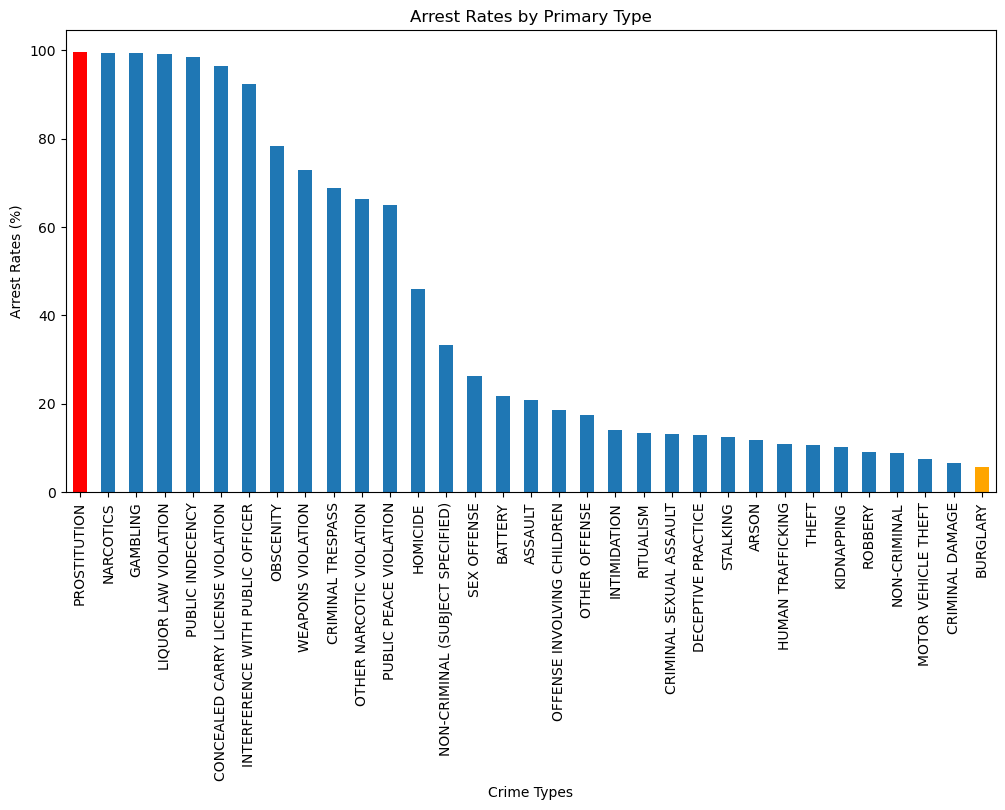

In [79]:
crime_arrest_sorted = crime_arrest.sort_values(by='Percent_Arrested (True)', ascending=False)

ax = crime_arrest_sorted.plot(kind='bar', y='Percent_Arrested (True)', legend=False, figsize=(12, 6))
max_index = crime_arrest_sorted['Percent_Arrested (True)'].idxmax()
min_index = crime_arrest_sorted['Percent_Arrested (True)'].idxmin()
ax.patches[crime_arrest_sorted.index.get_loc(max_index)].set_facecolor('red')
ax.patches[crime_arrest_sorted.index.get_loc(min_index)].set_facecolor('orange')

plt.title('Arrest Rates by Primary Type')
plt.xlabel('Crime Types')
plt.ylabel('Arrest Rates (%)')
plt.xticks(rotation=90)
plt.show()

Now, we can easily see that the crime type of prostitution has the highest arrest rate at about 99.6%, while the type of burglary has the lowest arrest rate at about 5.7%. This bar chart with each crime type on the x-axis and arrest rates on the y-axis, shows that most of the crime types have either high arrest rates greater than 60% or low arrest rates less than 20%. According to the distribution of crime types before, we found that 'theft' and 'battery' are the most frequent occurrences but their arrest rates are not the highest, which describes from the side that it is very difficult to catch this type of criminal. Again, it expresses crime types will influence arrest rates to a certain degree.

### $X_2$: Population Density of Community Areas

In this part, even though the variable is about the population density, the original dataset does not contain this information, I will focus on each community area's arrest rates without other factors first, then merge other datasets in the future steps to see the relationship between the population of the community area and the arrest rates.

In [69]:
# Create a pivot table to count the number of 'True' and 'False' in each community area
area_arrest = chicago_crime_clean.pivot_table(index='Community Area', columns='Arrest', aggfunc='size', fill_value=0)
area_arrest.columns = ['Arrested (False)', 'Arrested (True)']
area_arrest['Percent_Arrested (True)'] = (area_arrest['Arrested (True)'] / (area_arrest['Arrested (False)'] + 
                                                                              area_arrest['Arrested (True)'])) * 100
area_arrest_sorted = area_arrest.sort_values(by='Percent_Arrested (True)', ascending=False)
area_arrest = area_arrest.reset_index()

In [81]:
area_arrest.describe()

,Community Area,Arrested (False),Arrested (True),Percent_Arrested (True)
count,77.000000,77.000000,77.000000,77.000000
mean,39.000000,70291.792208,24099.012987,22.534966
std,22.371857,54214.181844,25795.026325,6.608262
min,1.000000,6387.000000,823.000000,10.383647
25%,20.000000,28961.000000,6857.000000,17.701992
50%,39.000000,53404.000000,14875.000000,22.382251
75%,58.000000,99376.000000,33282.000000,25.630492
max,77.000000,284329.000000,168020.000000,42.966774


The statistical table above shows arrest rates in all communities. As we can see, the average arrest rate is around 22.53%, and the community area with the lowest arrest rate is about 10.38%, while the highest is about 42.97%. There is still a gap between the two communities.

In [70]:
area_arrest.set_index('Community Area', inplace = True)
print(area_arrest.loc[area_arrest['Percent_Arrested (True)'].idxmax()])
print(area_arrest.loc[area_arrest['Percent_Arrested (True)'].idxmin()])

Arrested (False)           77811.000000
Arrested (True)            58620.000000
Percent_Arrested (True)       42.966774
Name: 26, dtype: float64
Arrested (False)           12100.000000
Arrested (True)             1402.000000
Percent_Arrested (True)       10.383647
Name: 12, dtype: float64


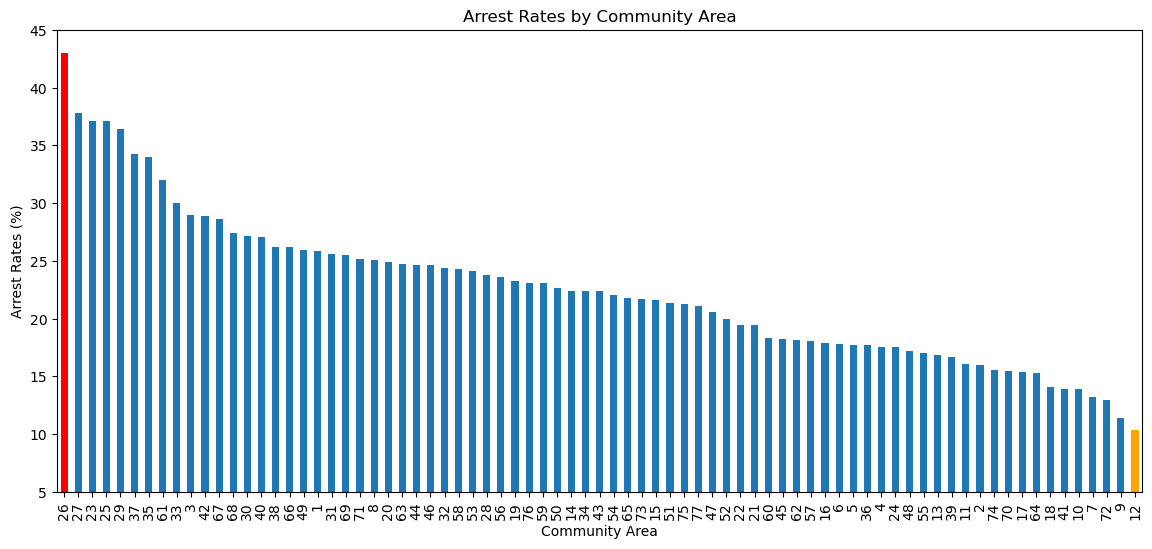

In [83]:
ax2 = area_arrest_sorted.plot(kind='bar', y='Percent_Arrested (True)', legend=False, figsize=(14, 6))
max_index2 = area_arrest_sorted['Percent_Arrested (True)'].idxmax()
min_index2 = area_arrest_sorted['Percent_Arrested (True)'].idxmin()
ax2.patches[area_arrest_sorted.index.get_loc(max_index2)].set_facecolor('red')
ax2.patches[area_arrest_sorted.index.get_loc(min_index2)].set_facecolor('orange')
plt.ylim(5,45)
plt.title('Arrest Rates by Community Area')
plt.xlabel('Community Area')
plt.ylabel('Arrest Rates (%)')
plt.show()

The bar plot above shows each community area with respect to arrest rates. Through observation, we can see that Area 12 has the lowest arrest rate at 10.4%, and Area 26 has the highest arrest rate at 43%. In addition, from the table above, the average arrest rate is about 22.5%, which is less than the arrest rates we have seen before based on the type of crime. We are interested in the root causes of the different arrest rates in different regions, so we might merge another dataset in future projects, like different regional economies.

### $X_3$: Year

In this section, we are going to study changes in arrest rates from year to year.

In [282]:
# Create a pivot table to count the number of 'True' and 'False' in each year
year_arrest = chicago_crime_clean.pivot_table(index='Year', columns='Arrest', aggfunc='size', fill_value=0)
year_arrest.columns = ['Arrested (False)', 'Arrested (True)']
year_arrest['Percent_Arrested (True)'] = (year_arrest['Arrested (True)'] / (year_arrest['Arrested (False)'] + 
                                                                              year_arrest['Arrested (True)'])) * 100
year_arrest_sorted = year_arrest.sort_values(by='Percent_Arrested (True)', ascending=False)
year_arrest = year_arrest.reset_index()

In [85]:
year_arrest.describe()

,Year,Arrested (False),Arrested (True),Percent_Arrested (True)
count,22.000000,22.000000,22.000000,22.000000
mean,2012.500000,246021.272727,84346.545455,24.214572
std,6.493587,50938.203752,39477.788173,6.452209
min,2002.000000,173138.000000,25025.000000,11.569934
25%,2007.250000,207865.000000,52870.750000,19.907587
50%,2012.500000,236506.000000,88518.000000,27.097991
75%,2017.750000,297128.750000,108642.250000,28.793249
max,2023.000000,331541.000000,144248.000000,31.170812


Again, this statistical table illustrates the information on arrest rates for years from 2002 to 2023. The average arrest rate is about 24.21%, and the highest arrest rate has reached 31.17%, but the lowest is around 11.57%. Now, I will plot arrest rates for each year in detail.

In [15]:
print(year_arrest.loc[year_arrest['Percent_Arrested (True)'].idxmax()])
print(year_arrest.loc[year_arrest['Percent_Arrested (True)'].idxmin()])

Year                         2005.000000
Arrested (False)           309646.000000
Arrested (True)            140230.000000
Percent_Arrested (True)        31.170812
Name: 3, dtype: float64
Year                         2022.000000
Arrested (False)           207166.000000
Arrested (True)             27105.000000
Percent_Arrested (True)        11.569934
Name: 20, dtype: float64


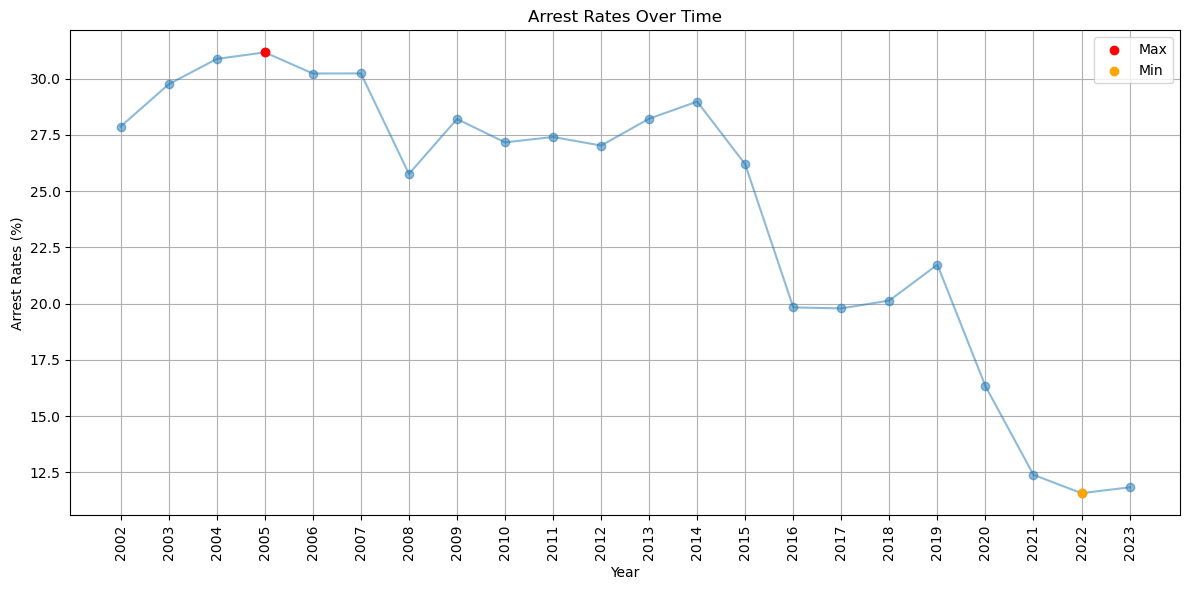

In [283]:
plt.figure(figsize=(12, 6))
plt.plot(year_arrest['Year'], year_arrest['Percent_Arrested (True)'], marker='o', linestyle='-', alpha=0.5, zorder=2)

max_index = year_arrest['Percent_Arrested (True)'].idxmax()
min_index = year_arrest['Percent_Arrested (True)'].idxmin()
plt.scatter(year_arrest['Year'][max_index], year_arrest['Percent_Arrested (True)'][max_index], 
            color='red', label='Max', zorder=3)
plt.scatter(year_arrest['Year'][min_index], year_arrest['Percent_Arrested (True)'][min_index], 
            color='orange', label='Min', zorder=3)

plt.title('Arrest Rates Over Time')
plt.xlabel('Year')
plt.ylabel('Arrest Rates (%)')
plt.grid(True)
plt.xticks(year_arrest['Year'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

The line chart above illustrates the arrest rates from 2002 to 2023. The maximum arrest rate was in 2005, which is 31.2%, and the minimum arrest rate was in 2022 at 11.6%. Moreover, we could see that there is a corner in 2008, and we might guess that is due to the 2008 recession but need more evidence. There are two sharp declines, one was in 2014, and another was in 2019. We should do more research to explain the phenomenon. Also, the statistics summary mentions the average arrest rate is about 24.2%.

### Combine Independent Variables

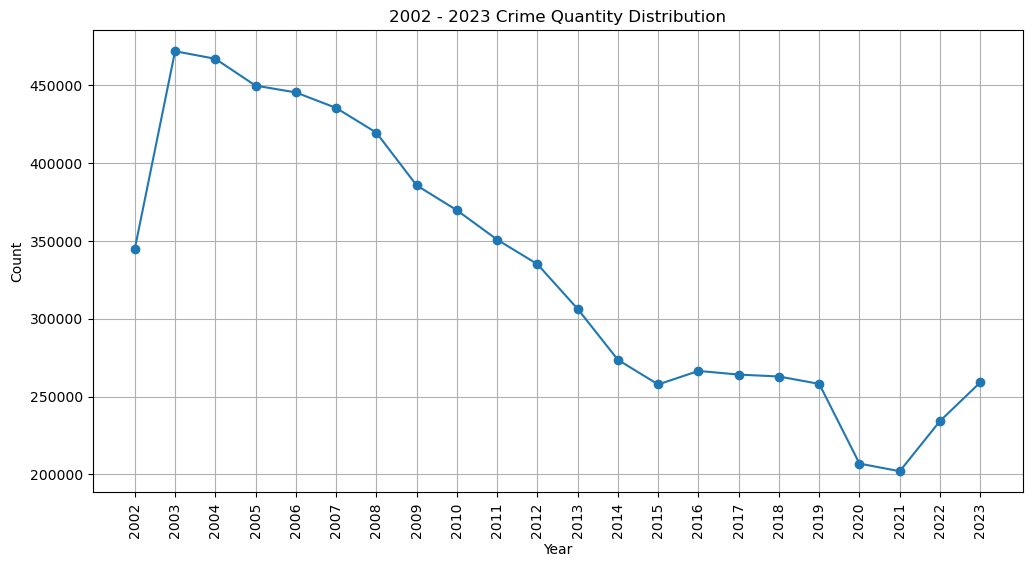

In [13]:
year_counts = chicago_crime_clean['Year'].value_counts().sort_index()

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(year_counts.index, year_counts.values, marker='o', linestyle='-')
plt.title('2002 - 2023 Crime Quantity Distribution')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(year_counts.index, rotation=90)
plt.grid(True)
plt.show()

The line chart above shows the variation in crime quantity from 2002 to 2023. It gives us a surprising result since the number of crimes peaked in 2003 and then continued to decline, reaching its lowest in 2021. We can see that the quantity changes are quite different with the arrest rates changing over time, so we want to explore how each primary type and community area influences arrest rates in each year.

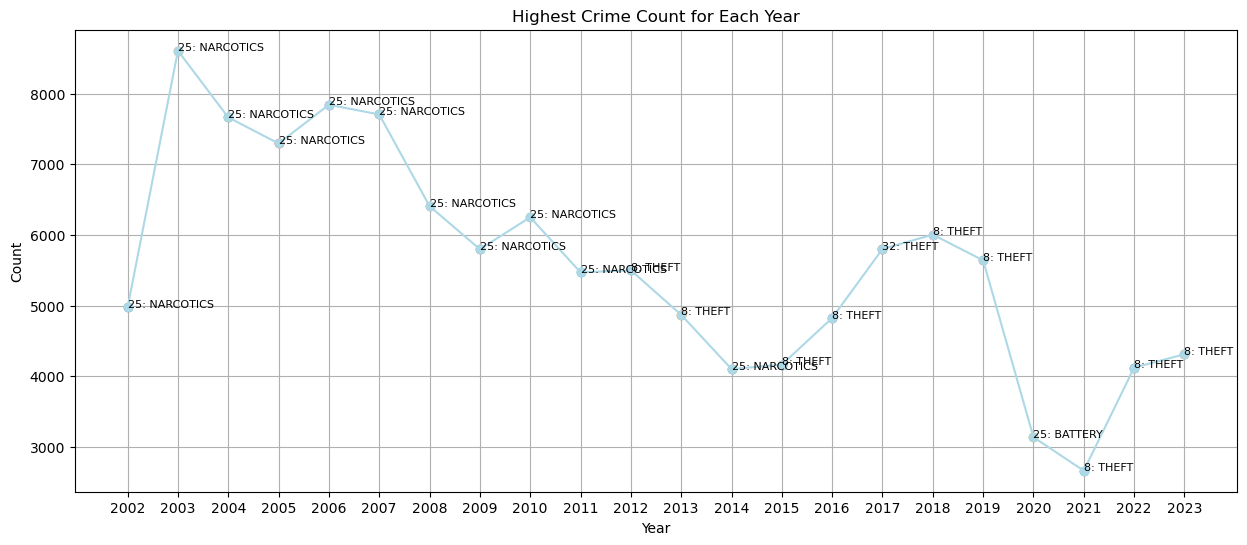

In [31]:
combine = chicago_crime_clean.groupby(['Community Area', 'Primary Type', 'Year']).size().reset_index(name='Count')
# Sort the DataFrame by Year and count
combine_sorted = combine.sort_values(by=['Year', 'Count'], ascending=[True, False])
new = combine_sorted.groupby('Year').head(1)

# Plot the graph
plt.figure(figsize=(15, 6))
for idx, row in new.iterrows():
    plt.scatter(row['Year'], row['Count'], label=f"{row['Community Area']}: {row['Primary Type']}")
    plt.text(row['Year'], row['Count'], f"{row['Community Area']}: {row['Primary Type']}", fontsize=8)

plt.plot(new['Year'], new['Count'], marker='o', linestyle='-', color='lightblue')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Highest Crime Count for Each Year')
plt.xticks(new['Year'])
plt.grid(True)
plt.show()

The graph above shows the highest crime count for each year, and each point mentions its community area and crime type. Different from the previous parts, I would like to combine three independent variables and observe the correlation between them and the arrest rate. Through observation, I found that among all the highest crime counts, in the year 2003, the crime type of narcotics in community area 25 is the highest; and theft in community area 8 of year 2021 is the lowest. Moreover, before 2014, the highest number of crimes per year is mostly in community area 25 and the narcotics category, while after 2014, they focus on community area 8 and theft primary type. The results are totally different from what I found before using a single variable. Therefore, I would guess that the combination of these variables will influence the arrest rate over time.

In [14]:
most_frequent_type_idx = combine.groupby('Community Area')['Count'].idxmax()
# Create a DataFrame with the most frequent 'Primary Type' for each 'Community Area'
most_frequent_types = combine.loc[most_frequent_type_idx][['Community Area', 'Primary Type', 'Count']]
# Count the number of areas where each crime type occurs the most
area_counts = most_frequent_types.groupby('Primary Type').size().reset_index(name='Area Count')
print(area_counts)

worst_frequent_type_idx = combine.groupby('Community Area')['Count'].idxmin()
# Create a DataFrame with the worst frequent 'Primary Type' for each 'Community Area'
worst_frequent_types = combine.loc[worst_frequent_type_idx][['Community Area', 'Primary Type', 'Count']]
# Count the number of areas where each crime type occurs the worst
area_counts2 = worst_frequent_types.groupby('Primary Type').size().reset_index(name='Area Count')
print(area_counts2)

        Primary Type  Area Count
0            BATTERY          23
1    CRIMINAL DAMAGE           7
2  CRIMINAL TRESPASS           1
3          NARCOTICS           7
4              THEFT          39
                        Primary Type  Area Count
0                              ARSON          51
1  CONCEALED CARRY LICENSE VIOLATION          23
2                           GAMBLING           2
3                           HOMICIDE           1


Here, it represents 5 types of crime that occur the most in each area of Chicago and 4 types of crime that occur the least from 2002 to 2023. We know that in 77 community areas, theft is the most common crime in these areas, which happened the most frequently in 39 areas. Battery is the second-highest crime type in 23 out of 77 areas. On the contrary, there are 51 areas where arson occurs the least in all of the crime types.

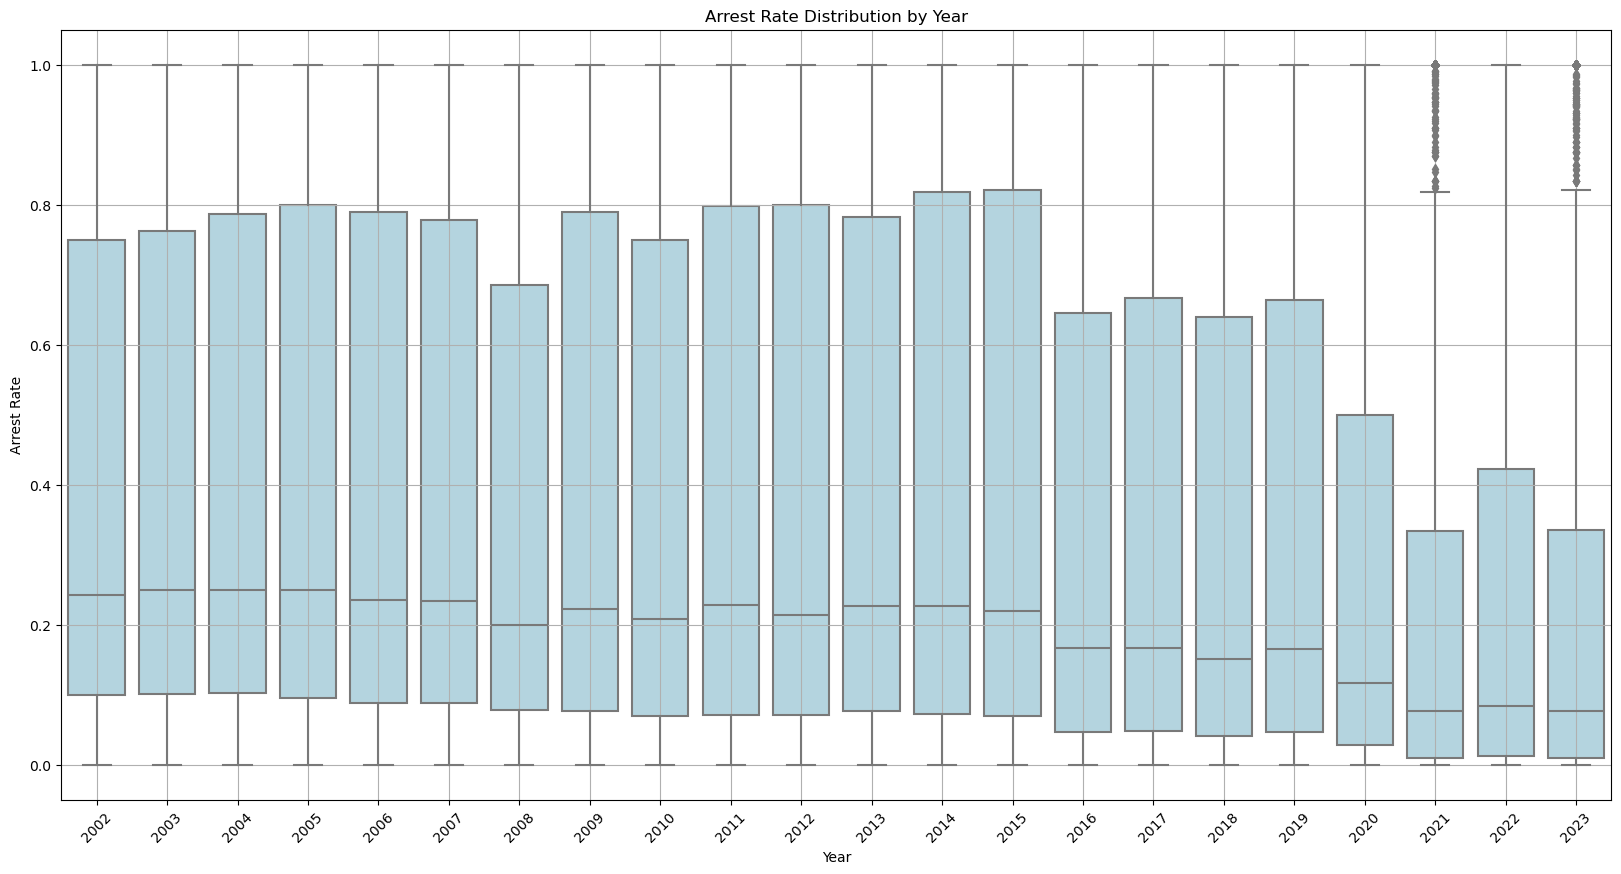

In [50]:
combine_new = chicago_crime_clean.groupby(['Community Area', 'Primary Type', 'Year']).agg({'Arrest':['mean']}).reset_index()
plt.figure(figsize=(20, 10))
sns.boxplot(data=combine_new, x='Year', y=('Arrest', 'mean'), color='lightblue')
plt.title('Arrest Rate Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Arrest Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [59]:
combine_new

Arrest
                                           mean
Community Area Primary Type      Year          
1              ARSON             2002  0.000000
                                 2003  0.181818
                                 2004  0.066667
                                 2005  0.200000
                                 2006  0.400000
...                                         ...
77             WEAPONS VIOLATION 2019  1.000000
                                 2020  0.200000
                                 2021  0.166667
                                 2022  0.692308
                                 2023  0.647059

[40268 rows x 1 columns]

This boxplot of arrest rate distribution is different from the plot of arrest rate over time before. In the last graph, I only consider one variable which is years, but in this boxplot, I combine all three variables, community areas, crime types, and years, so it actually shows the distribution of arrest rates based on primary types and each area for every year. As we can see, in the years 2021 and 2023, their arrest rates are concentrated below 40%, and so arrest rates higher than 81% become outliers. The boxplot considers the interplay between crime types and demographic factors to influence the arrest rates.

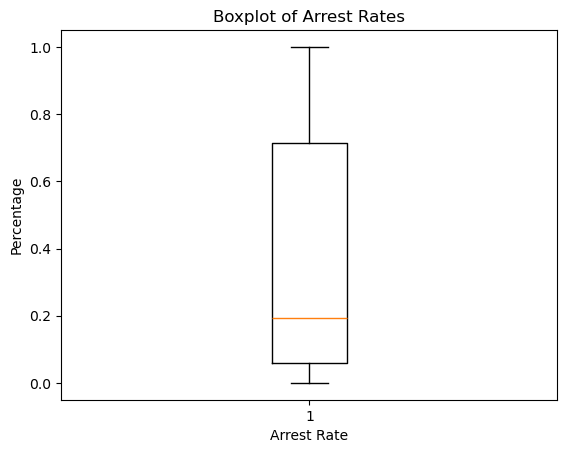

,Arrest
,mean
count,40268.000000
mean,0.364232
std,0.374328
min,0.000000
25%,0.059829
50%,0.193025
75%,0.714286
max,1.000000


In [53]:
combine_new = chicago_crime_clean.groupby(['Community Area', 'Primary Type', 'Year']).agg({'Arrest':['mean']})

# Create a boxplot for arrest rates
plt.boxplot(combine_new)
plt.title('Boxplot of Arrest Rates')
plt.xlabel('Arrest Rate')
plt.ylabel('Percentage')
plt.show()
combine_new.describe()

The boxplot of arrest rates represents the arrest rates based on 33 crime types, 77 community areas, and whole years. We can see that its min is 0% and max is 100%, also its average is around 36.4%, but the median rate is only around 19.3% and is a right-skewed plot. According to the box plot, the 25th percentile of the arrest rate is around 6% and the 75th percentile is around 71.4%, which is a huge difference.

# Project 2

## 2.1 The Message

Based on my previous findings, demographic characteristics and economic factors within community areas, and different crime types collectively influence arrest rates.

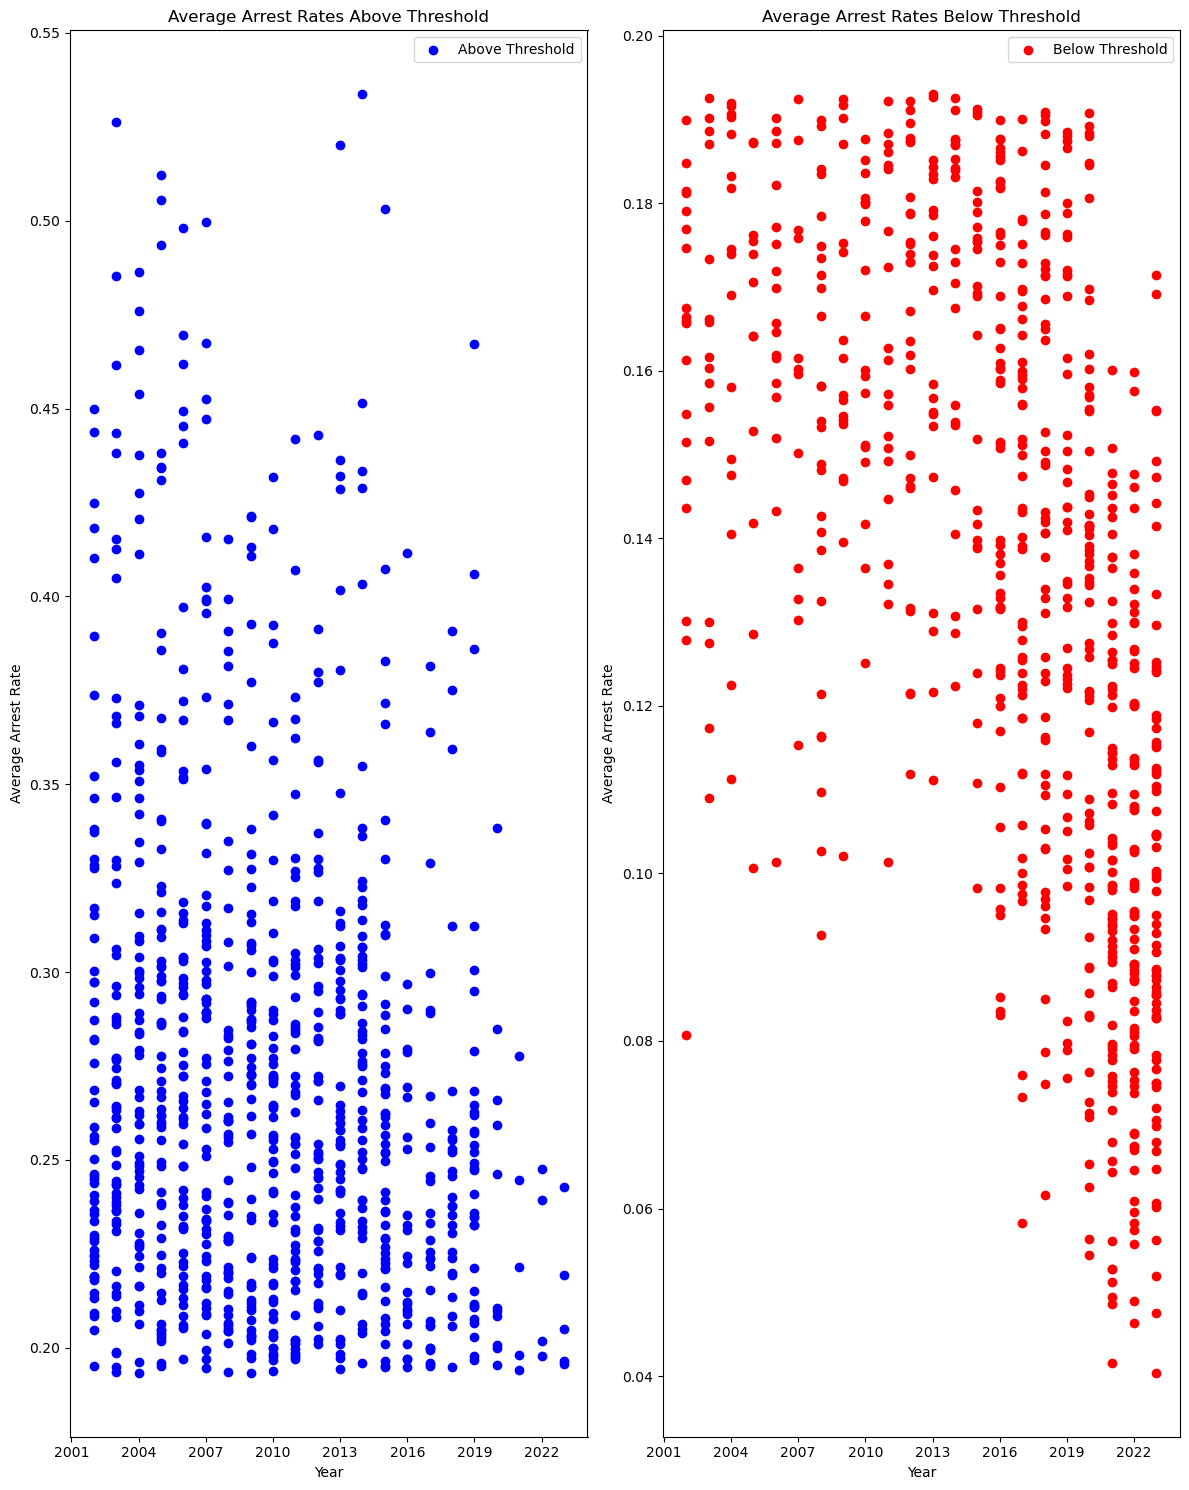

In [297]:
average_arrest_rate_yearly = chicago_crime_clean.groupby(['Year', 'Community Area'])['Arrest'].mean().reset_index()

# Split data into two dataframes based on average arrest rate threshold
above_threshold = average_arrest_rate_yearly[average_arrest_rate_yearly['Arrest'] > 0.193025]
below_threshold = average_arrest_rate_yearly[average_arrest_rate_yearly['Arrest'] <= 0.193025]

# Create scatter plot with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 15))
    
# Plot above threshold data
axs[0].scatter(above_threshold['Year'], above_threshold['Arrest'], label='Above Threshold', color='blue')
axs[0].set_title('Average Arrest Rates Above Threshold')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Average Arrest Rate')
axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Plot below threshold data
axs[1].scatter(below_threshold['Year'], below_threshold['Arrest'], label='Below Threshold', color='red')
axs[1].set_title('Average Arrest Rates Below Threshold')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Average Arrest Rate')
axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add legend
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

!!!!!I separate 33 primary types into two groups, violent and non-violent; and then show their corresponding arrest rates over time. The line chart presents that the arrest rates for violent crimes do not much change, ranging from 20% to 25%; but the arrest rates for non-violent crimes have a big difference, there was a sudden decline in 2019. Moreover, both of them had a local minimum in 2008; now we know that previously we found the lowest arrest rate in 2022 mainly due to the low arrest rate for nonviolent crimes during that year, and the highest arrest rate in 2005 was also due to the high arrest rate for nonviolent crimes. I will show more specifics about how each primary type changes in the next graph.

## 2.2 Maps and Interpretations

### Merging with a New Dataset

The new dataset I have chosen is per capita income in Chicago starting from 2006 to 2022 and divided into four periods, which is from the American Community Survey and collected by the Chicago Health Atlas, and this dataset is statistically classified by community name. It provides a crucial socio-economic dimension to my analysis of crime trends in Chicago. By merging this new dataset, I can observe how per capita income levels have evolved and potentially impacted various aspects of community life, including crime rates and law enforcement responses so that research how fluctuations in per capita income may intersect with crime trends across Chicago's diverse communities and then affect arrest rates. I call this new dataset 'per_capita_income', and I will also clean this data by dropping missing values. In the end, I am going to combine the new dataset into 'chicago_crime_clean' based on community area and call it 'merge'.

In [229]:
relative_path2 = os.path.join('..', 'Data', 'per_capita_income.csv')
abs_path2 = os.path.abspath(relative_path2)

# Read the CSV file
per_capita_income = pd.read_csv(abs_path2)

In [218]:
per_capita_income.isnull().any(axis=0)

Layer             True
Name              True
GEOID             True
Longitude         True
Latitude          True
PCI_2018-2022    False
PCI_2014-2018    False
PCI_2010-2014    False
PCI_2006-2010    False
dtype: bool

In [221]:
per_capita_income.dtypes

Layer             object
Name              object
GEOID            float64
Longitude        float64
Latitude         float64
PCI_2018-2022     object
PCI_2014-2018     object
PCI_2010-2014     object
PCI_2006-2010     object
dtype: object

In [230]:
per_capita_income = per_capita_income.dropna()
per_capita_income = per_capita_income.drop(['Longitude','Latitude','Layer'],axis=1)
per_capita_income['GEOID'] = per_capita_income['GEOID'].astype(int)
per_capita_income['PCI_2006-2010'] = per_capita_income['PCI_2006-2010'].astype(float)
per_capita_income['PCI_2010-2014'] = per_capita_income['PCI_2010-2014'].astype(float)
per_capita_income['PCI_2014-2018'] = per_capita_income['PCI_2014-2018'].astype(float)
per_capita_income['PCI_2018-2022'] = per_capita_income['PCI_2018-2022'].astype(float)

In [231]:
merge = pd.merge(chicago_crime_clean, per_capita_income, left_on='Community Area', right_on='GEOID', how='left')

In [233]:
merge['Per Capita Income'] = (merge['PCI_2018-2022'] + merge['PCI_2014-2018'] +
                              merge['PCI_2010-2014'] + merge['PCI_2006-2010'])/4
merge = merge.drop(['GEOID','Date','PCI_2018-2022','PCI_2010-2014','PCI_2014-2018','PCI_2006-2010'],axis=1)

### Maps

In [66]:
merge['Location'] = list(zip(merge.Longitude, merge.Latitude))
merge['Location'] = merge['Location'].apply(Point)

In [67]:
shapefile_path = os.path.join('..', 'Data', 'Boundaries - Community Areas (current).zip')
chicago_shape = gpd.read_file(shapefile_path)

In [71]:
chicago_shape['area_numbe'] = chicago_shape['area_numbe'].astype('int32')
merged_df = chicago_shape.merge(area_arrest, left_on="area_numbe", right_on='Community Area')

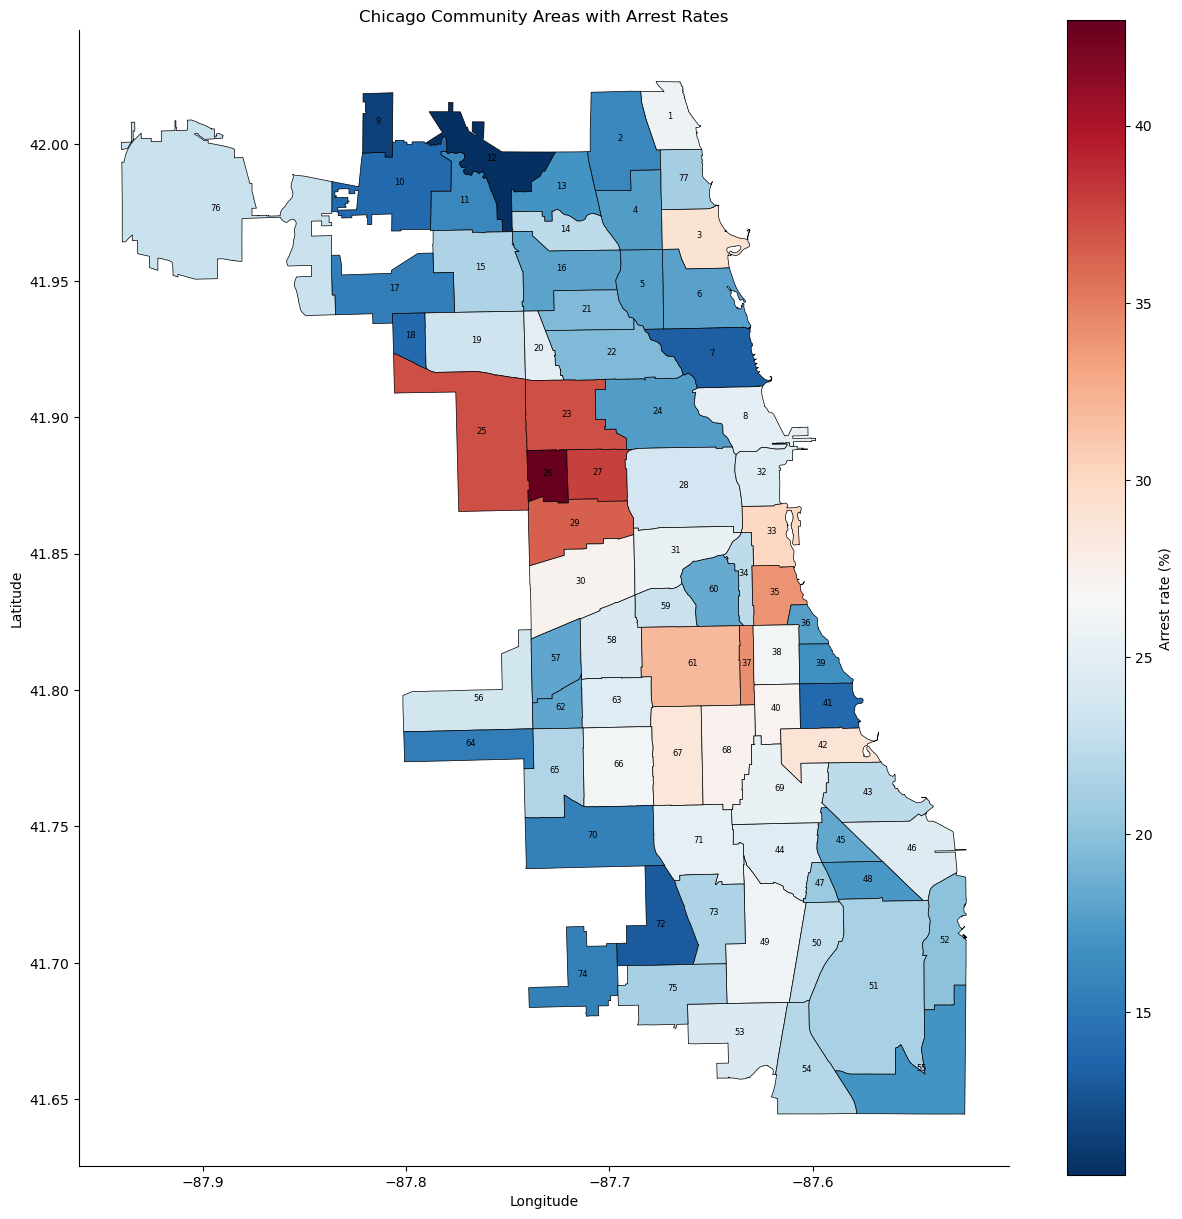

In [73]:
fig, gax = plt.subplots(figsize=(15, 15))

merged_df.plot(ax=gax, column='Percent_Arrested (True)', cmap='RdBu_r', legend=True,
               legend_kwds={'label': 'Arrest rate (%)'}, edgecolor='black', linewidth=0.5)

for idx, row in merged_df.iterrows():
    gax.annotate(text=str(row['area_numbe']), xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                horizontalalignment='center', fontsize=6)
plt.title('Chicago Community Areas with Arrest Rates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

The map above shows the arrest rates in 77 community areas in Chicago. As we can see, West Garfield Park (area 26) has the highest arrest rate, and Forest Glen (area 12) has the lowest arrest rate. It is worth noting that a couple of areas around West Garfield Park also have high arrest rates. Also, most of the north side of Chicago have lower arrest rates. The map as a whole is in light blue, the same as when we analyzed the relationship between community areas and arrest rates separately, the average is around 22.5%. Later, I will create a map that present relationship between crime quantity with community areas.

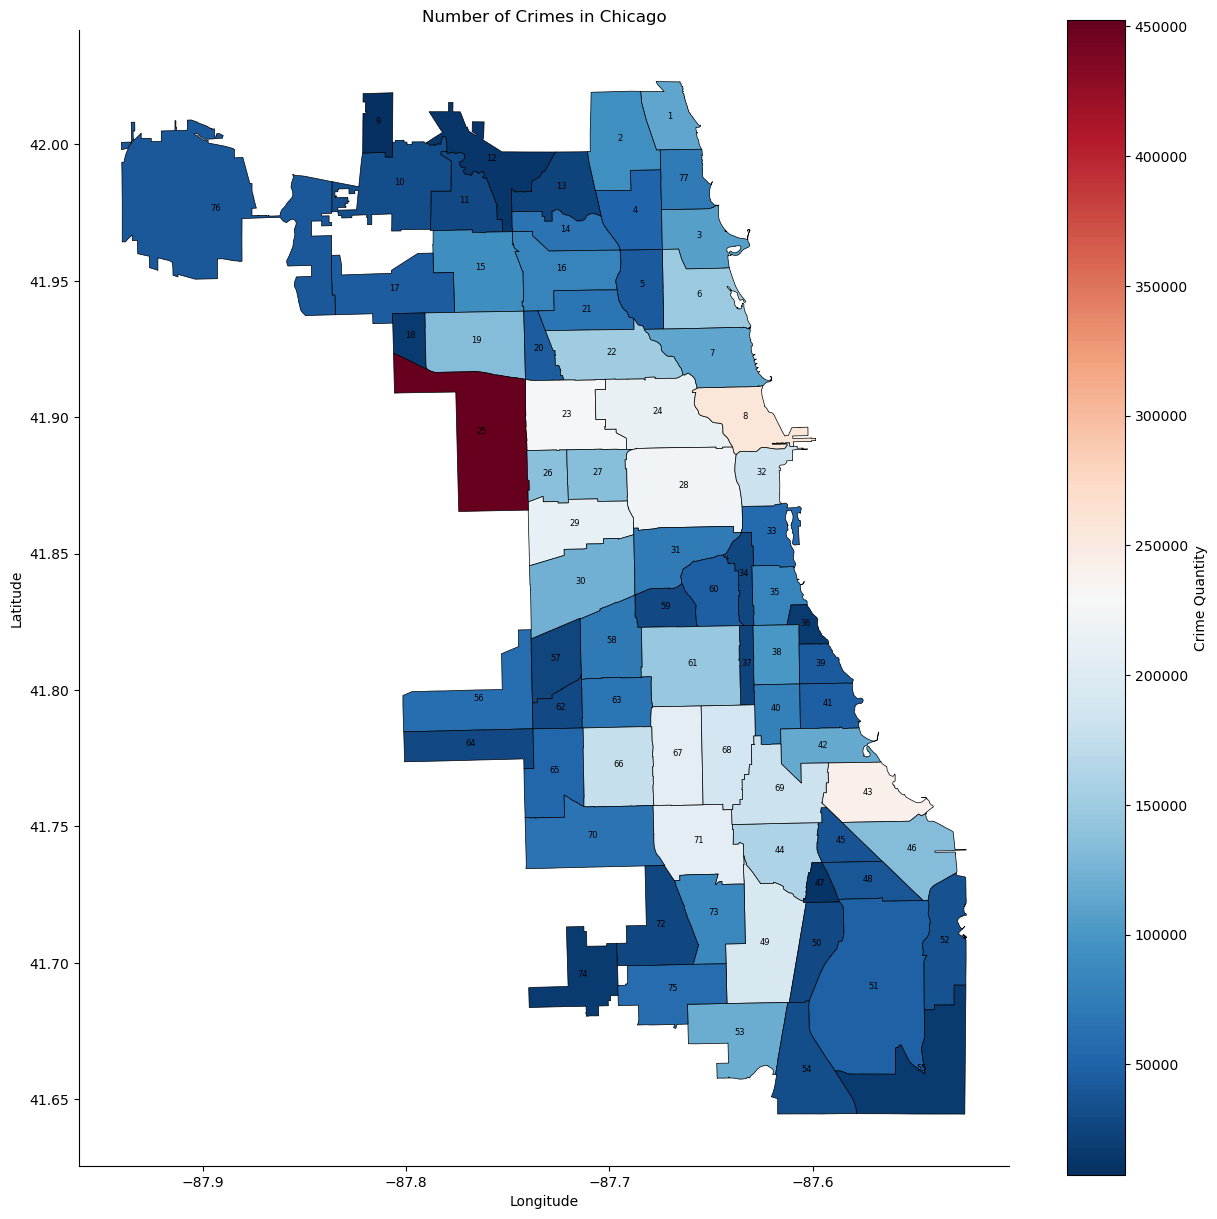

In [100]:
crime_area_counts = chicago_crime_clean['Community Area'].value_counts()
merged_df2 = chicago_shape.merge(crime_area_counts, left_on="area_numbe", right_on='Community Area')
fig, gax = plt.subplots(figsize=(15, 15))

merged_df2.plot(ax=gax, column='count', cmap='RdBu_r', legend=True,
               legend_kwds={'label': 'Crime Quantity'}, edgecolor='black', linewidth=0.5)

for idx, row in merged_df2.iterrows():
    gax.annotate(text=str(row['area_numbe']), xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                horizontalalignment='center', fontsize=6)
plt.title('Number of Crimes in Chicago')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

In analyzing the distribution of crime across Chicago's community areas, I observe notable disparities, particularly in areas such as Austin (area 25), which exhibits a disproportionately high number of crimes compared to others. This finding underscores the multifaceted interplay between crime types, demographic characteristics, and law enforcement practices as outlined in the research question. Moreover, this examination reveals intriguing variations in arrest rates across different areas. While some areas with lower crime quantities demonstrate commendable arrest rates, others, particularly on the north side of Chicago, exhibit lower arrest rates despite comparable crime levels. Notably, the Near North Side (area 8) presents an interesting case where a higher incidence of certain crimes, such as prostitution, does not correspond to a proportionately higher arrest rate. This underscores the complexity of factors influencing law enforcement outcomes within distinct community contexts, warranting further investigation into the nuanced dynamics between crime occurrence, arrest practices, and community characteristics. It is worth noting that I did not consider population density for each community area yet, there might be some errors caused by that, but I will do that later.


In [94]:
primary_types = chicago_crime_clean['Primary Type'].unique()
violent_crimes = ['ASSAULT', 'WEAPONS VIOLATION', 'HOMICIDE', 'SEX OFFENSE', 'ROBBERY', 
                  'CRIMINAL SEXUAL ASSAULT', 'KIDNAPPING']

# Categorize primary types into violent and non-violent crimes
violent_types = [pt for pt in primary_types if pt in violent_crimes]
non_violent_types = [pt for pt in primary_types if pt not in violent_crimes]

violent_data = chicago_crime_clean[chicago_crime_clean['Primary Type'].isin(violent_types)]
non_violent_data = chicago_crime_clean[chicago_crime_clean['Primary Type'].isin(non_violent_types)]

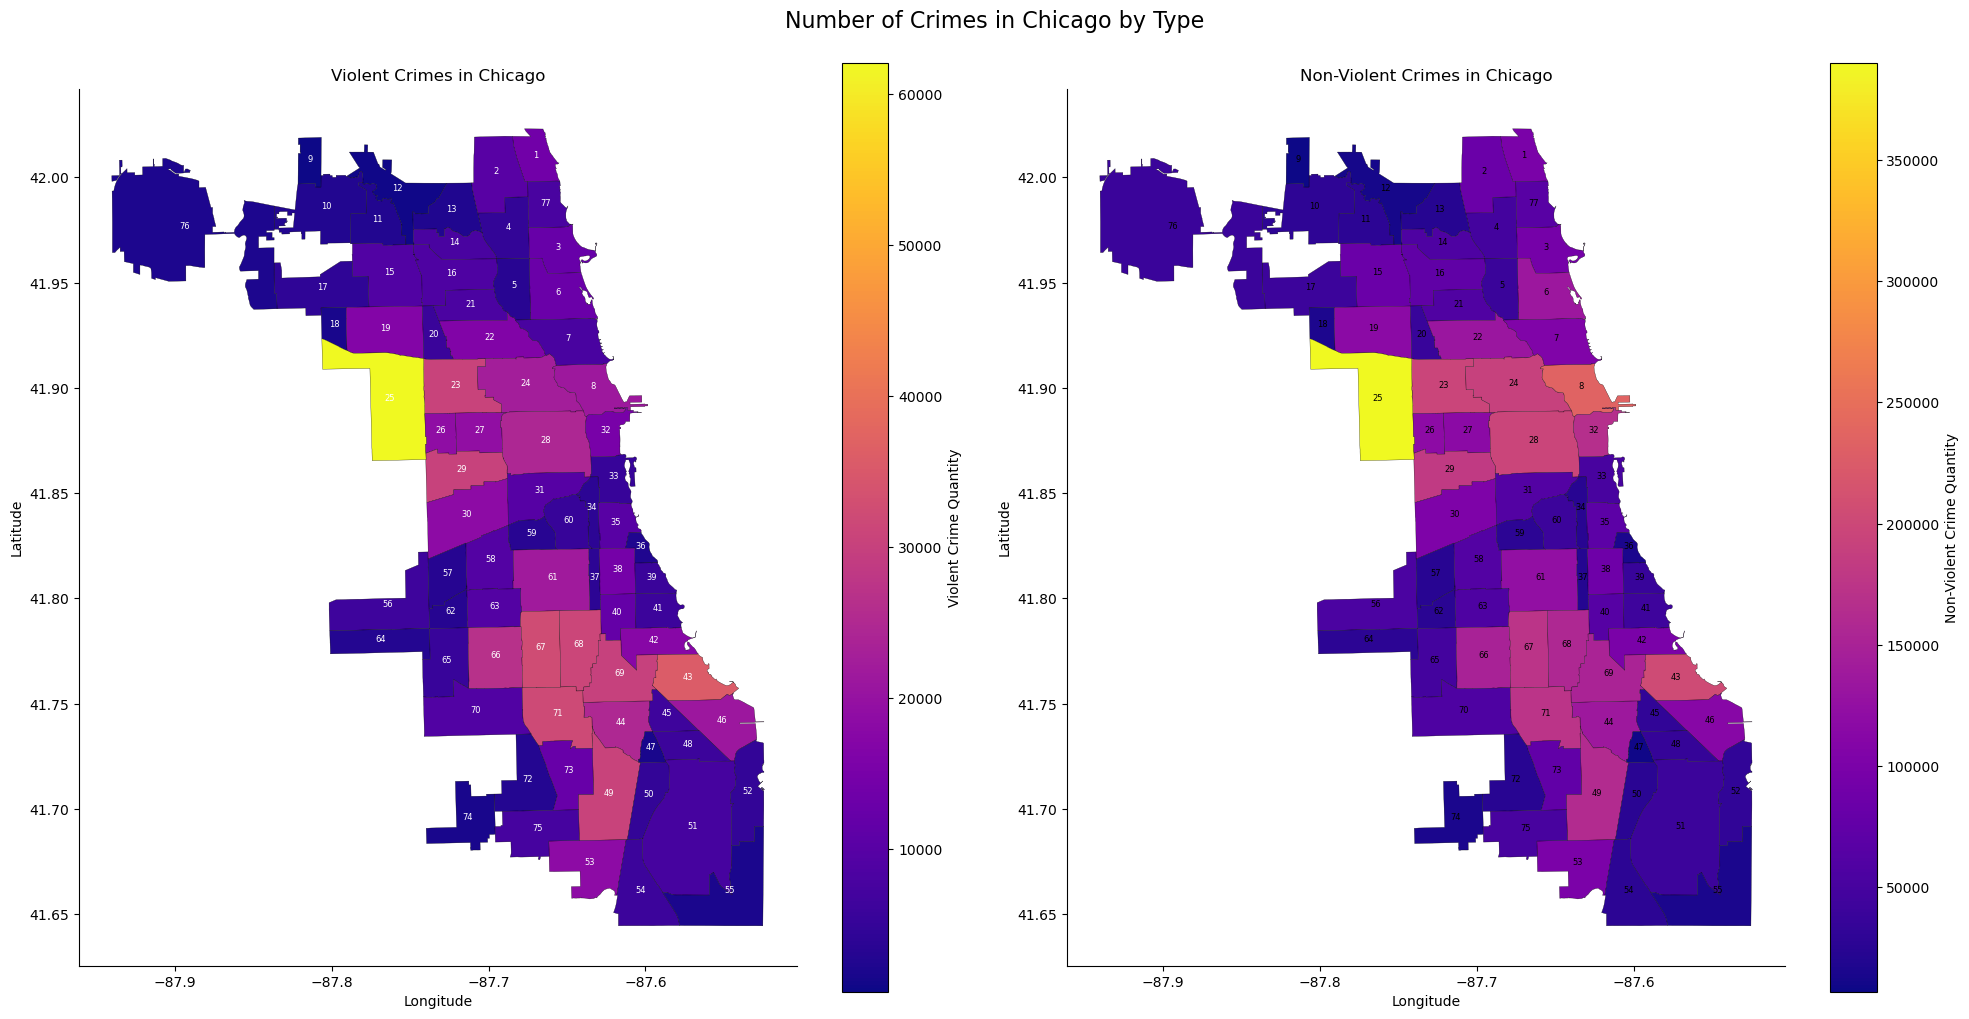

In [95]:
violent_data_counts = violent_data['Community Area'].value_counts()
non_violent_data_counts = non_violent_data['Community Area'].value_counts()
merged_df3 = chicago_shape.merge(violent_data_counts, left_on="area_numbe", right_on='Community Area')
merged_df4 = chicago_shape.merge(non_violent_data_counts, left_on="area_numbe", right_on='Community Area')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
merged_df3.plot(ax=axes[0], column='count', cmap='plasma', legend=True, legend_kwds={'label': 'Violent Crime Quantity'},
               edgecolor='black', linewidth=0.2)
axes[0].set_title('Violent Crimes in Chicago')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
for idx, row in merged_df3.iterrows():
    axes[0].annotate(text=row['area_numbe'], color='white',xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                     horizontalalignment='center', fontsize=6)

merged_df4.plot(ax=axes[1], column='count', cmap='plasma', legend=True, legend_kwds={'label': 'Non-Violent Crime Quantity'},
               edgecolor='black', linewidth=0.2)
axes[1].set_title('Non-Violent Crimes in Chicago')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
for idx, row in merged_df4.iterrows():
    axes[1].annotate(text=row['area_numbe'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                     horizontalalignment='center', fontsize=6)

plt.suptitle('Number of Crimes in Chicago by Type', fontsize=16, x=0.5, y=1)
plt.tight_layout()
plt.show()

Now, I separate crime types into two groups, violent and non-violent, to see if the number of violent and nonviolent crimes in each area does not differ much
. It is clear to see hothese two groups of crime types are distributed in each community area by map. To keep the map clean and not messy, I use two colors for each submap to label the areasph. According to two maps, there is no doubt that Austin (area 25) has the highest quantity of both violent and non-violent crimes, but the number of non-violent crimes is much higher than violent crimes. Moreover, the distribution of the two types is roughly the same in 77 areas, but the non-violent crimes quantity are greater than violent crimes overall, so we might conclude that non-violent crime is the main factor affecting the arrest rat Again, here I still did not consider population density, but we can also observe a general situation of distribution of two groups of crime types.e.

In [239]:
merge_con1 = merge.groupby('Community Area')['Per Capita Income'].mean()

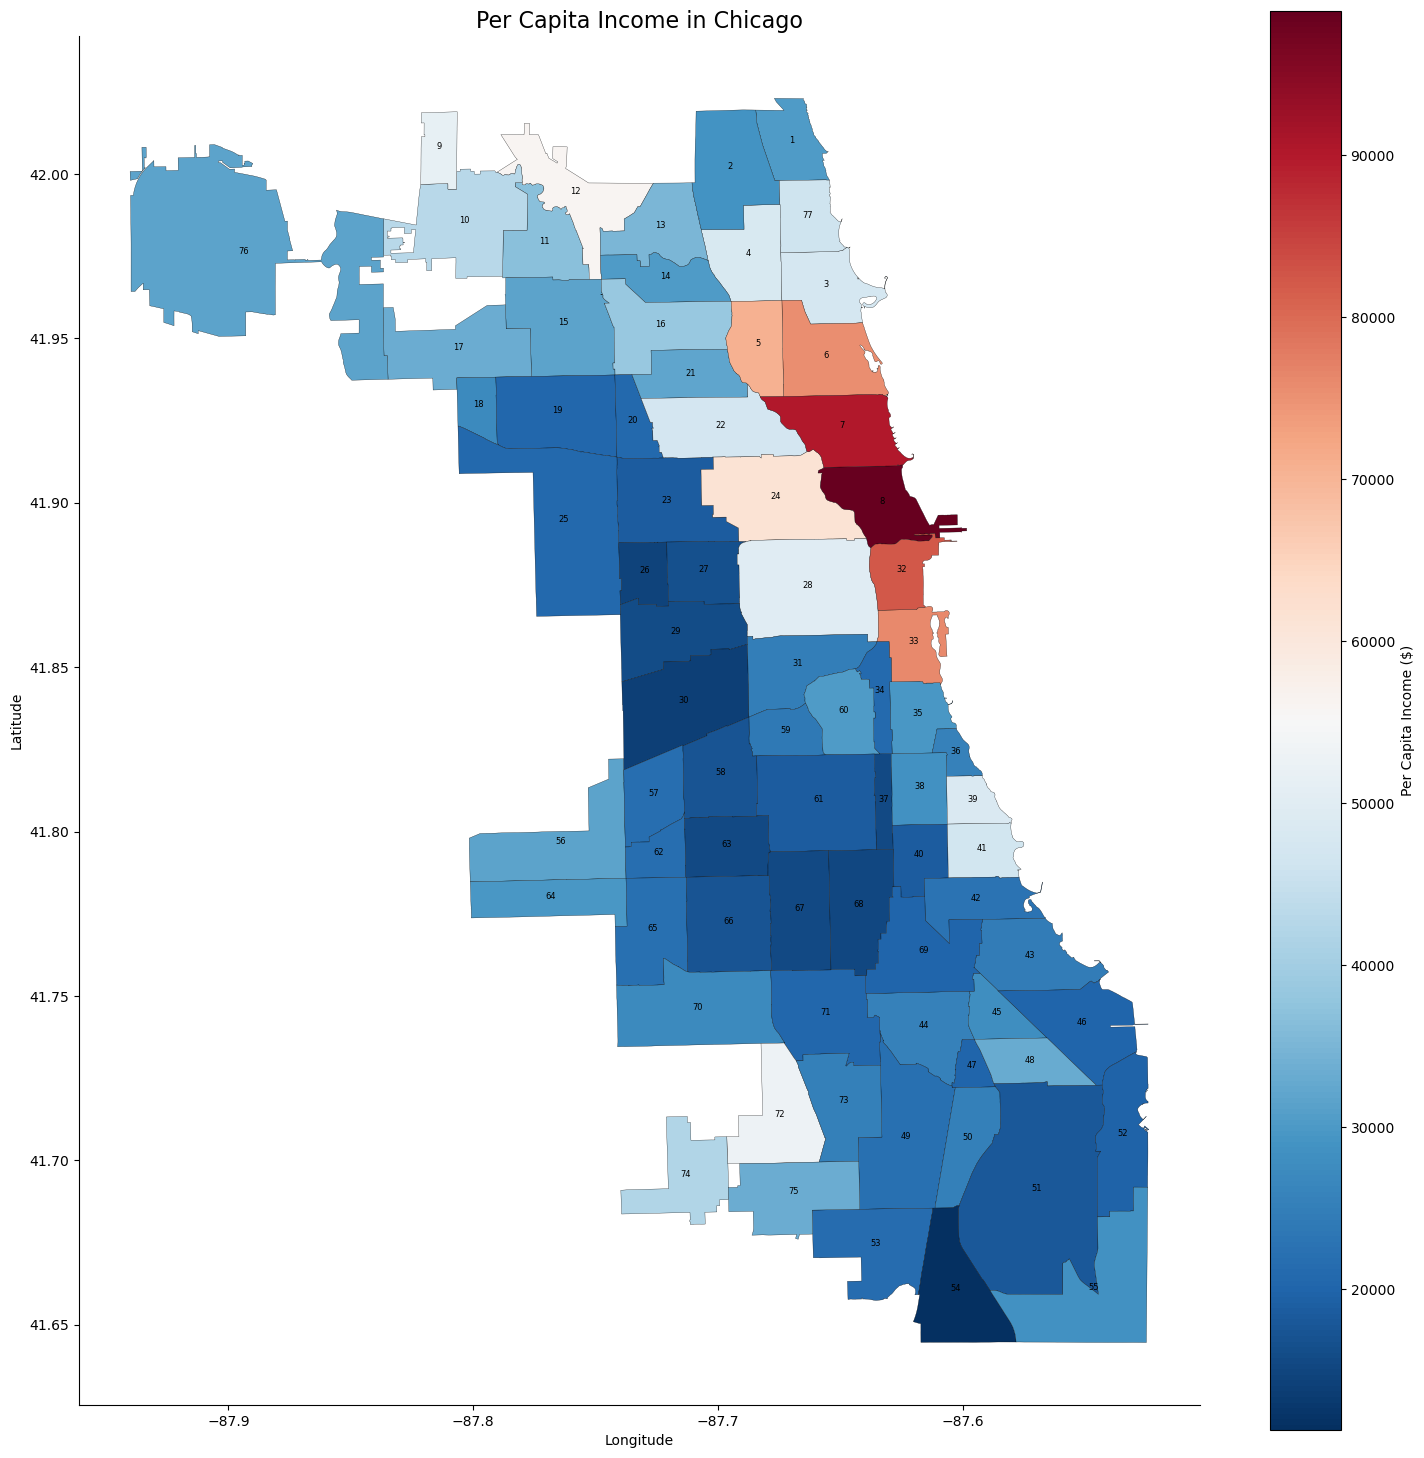

In [240]:
merged_df5 = chicago_shape.merge(merge_con1, left_on="area_numbe", right_on='Community Area')

fig, gax = plt.subplots(figsize=(15, 15))
merged_df5.plot(ax=gax, column='Per Capita Income', cmap='RdBu_r', legend=True, 
                   legend_kwds={'label': 'Per Capita Income ($)'}, edgecolor='black', linewidth=0.2)

for idx, row in merged_df5.iterrows():
    gax.annotate(text=str(row['area_numbe']), xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    horizontalalignment='center', fontsize=6)

plt.title('Per Capita Income in Chicago', fontsize=16, x=0.5, y=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

The map above presents the per capita income in Chicago. As we can see, Near North Side (area 8) has the highest per capita income for all periods. This data might be used to explain why Near North Side (area 8) has a higher crime quantity but lower arrest rates, but I still need to find more information about it, like Police resources and race distribution. Overall, the per capita income of each community area in Chicago is increasing year by year, but the gap between rich and poor areas is still growing because some areas are growing faster and some less. If we divide Chicago into two groups, per capita income in the Northeast as a whole would be slightly higher than elsewhere. Combining the previous map of "Number of Crimes in Chicago", Near North Side (area 8) is also the second-highest area where crime incidents occur, but its arrest rate is only around 25% by the map of "Chicago Community Areas with Arrest Rates". In addition, it seems like areas with lower per capita incomes have higher rates of violent crime.

# Project 3

## 3.1 Potential Data to Scrape

To enhance the research on the influence of crime types on arrest rates in various areas of Chicago, acquiring data on criminal population demographics by community areas would provide valuable insights. By obtaining a criminal population survey, I can gather information on the demographic characteristics of individuals involved in criminal activities within specific neighbourhoods.

The Chicago Police website (https://publicsearch1.chicagopolice.org/Arrests) serves as a potential source for such data, offering a comprehensive list of crime types for adult arrest records. This dataset includes details such as the individual's name, current age, arrest date, and district of arrest.

By merging this new dataset with existing data on arrest rates, crime quantities, and per capita income in each community area, I can explore potential correlations between demographic factors and crime outcomes. For instance, analyzing whether certain types of crimes are more commonly committed by males or females could shed light on gender disparities in criminal behaviour and law enforcement outcomes. Additionally, investigating whether arrest rates vary based on demographic characteristics such as age or socioeconomic status can provide insights into disparities in policing practices across different community areas.

## 3.2 Potential Challenges

There are several challenges when scraping the website. 

1. The first challenge revolves around the frequency of data updates on the website. It is unclear whether the website updates its crime data daily, monthly, quarterly, or annually. This uncertainty necessitates regular checks over time to ensure that the data used for analysis is current and accurate.

2. Another challenge is the variability in crime types and their corresponding naming conventions on the website. The names of crimes listed may differ from those used in my research project, requiring meticulous identification and mapping of each crime type. Additionally, websites with multiple filters and dynamic content often have complex HTML structures, making it challenging to accurately locate and extract the required data. This complexity adds to the time and effort required for scraping, as each crime type must be individually identified and scraped to ensure comprehensive data collection.

3. Some crucial data, such as gender distribution or crime rates in specific districts need clicking on the "Details" button, leading to additional pages with relevant information. Navigating through these pages and extracting the desired data adds another layer of complexity to the web scraping process.

4. It looks like the website only records data before 2014, however, I want to research the years between 2002 to 2023. The lack of historical data beyond a certain point restricts the scope of my analysis and may introduce biases or gaps in the findings. Hence, it might not so perfect for me to use in this project.

After trying to scrape the website that I want to use, it is difficult beyond imagination. Firstly, I found that it does not show the community area, instead, it shows districts and beats, which are not the category I want. Also, there are a lot of pages of data, which means I am going to have to click on a page again and scrape them.

Overall, the complexity of navigating web scraping, coupled with the inherent limitations of available data sets, presents huge challenges in obtaining the information necessary to effectively achieve research objectives.

## 3.3 Scraping Data from a Website

In this part, I will scrape the average temperature from 2010 to 2019 of Chicago from the Current Results website (https://www.currentresults.com/Weather/Illinois/Places/chicago-temperatures-by-month-average.php). One variable in my project is the year and the arrest rate can fluctuate from year to year depending on the climate of the year, so this temperature dataset can help me analyze how the crime quantity and arrest rates changed by the temperature or whether there is a correlation between temperature and crime count and arrest rates.

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [24]:
web_url = 'https://www.currentresults.com/Weather/Illinois/Places/chicago-temperatures-by-month-average.php'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

response = requests.get(web_url, headers=headers)

First of all, I need to define the URL of the website I want to scrape, and then the headers contain information about the user agent, which helps to identify the browser making the request. In this case, it simulates a request made by the Chrome browser on a Windows system. Lastly in this part, I need to request the URL.

In [36]:
soup_object = BeautifulSoup(response.content)
data_table = soup_object.find_all('table', "articletable tablecol-3-left revcolr")[0]
all_values = data_table.find_all('tr') # Prints the captured tag elements

Here, the BeautifulSoup is a library for parsing HTML documents, which allows me to extract data from HTML. Then, I will find the relevant tags to extract data. In this case, "table" is a tag and "articletable tablecol-3-left revcolr" is a class, the [0] at the end retrieves the first table found with this class name. In the end, I extract all these rows of values into a list by finding the 'tr' values from data_table.

In [102]:
temperature_avg = pd.DataFrame(columns = ['High_F', 'Low_F', 'Month', 'High_C', 'Low_C'])
ix = 0

for row in all_values[1:13]:
    values = row.find_all('td') # Extract all elements with tag <td>
    # Pick only the text part from the <td> tag
    High_F = values[0].text
    Low_F = values[1].text
    Month = values[2].text
    High_C = values[3].text
    Low_C = values[4].text
    
    temperature_avg.loc[ix] = [High_F, Low_F, Month, High_C, Low_C]
    ix += 1

I create an empty DataFrame with specified column names: 'High_F', 'Low_F', 'Month', 'High_C', and 'Low_C'. This data frame will eventually store the temperature data. In the for loop, I start from the second row and end with the 12th row, since the last row is the average temperature for the years, find all elements with the 'td' tag within the current row, and then extract the text content of each cell respectively. Lastly, assign the extracted values to the data frame "temperature_avg" at the current index.

In [103]:
temperature_avg.to_csv('Chicago_10years_temperature_avg.csv', index=False)

The data frame can be sorted as a csv file now, called "Chicago_10years_temperature_avg".

## 3.4 Visualizing the Scraped Dataset

In [101]:
temp_avg = pd.read_csv('Chicago_10years_temperature_avg.csv')

In [125]:
# Only keep the month
chicago_crime_clean['Month'] = pd.to_datetime(chicago_crime['Date']).dt.month

month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 
               9: 'September', 10: 'October', 11: 'November', 12: 'December'}
month_chicago = chicago_crime_clean
month_chicago['Month'] = month_chicago['Month'].map(month_names)

In [127]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_chicago['Month'] = pd.Categorical(month_chicago['Month'], categories=month_order, ordered=True)
month_chicago = month_chicago.groupby('Month', observed=True).size().reset_index(name='Crime_Count')
scaling_factor = 10000
month_chicago['Crime_Count (k)'] = Chicago_month['Crime_Count'] / scaling_factor

Here is a new table called "Chicago_month" which groups by months, and since I want to plot the number of crimes for each month and the average temperature I scraped before, I increased the units of crime count to thousands so that the gap between average temperature and crime quantities would not be so huge in numbers.

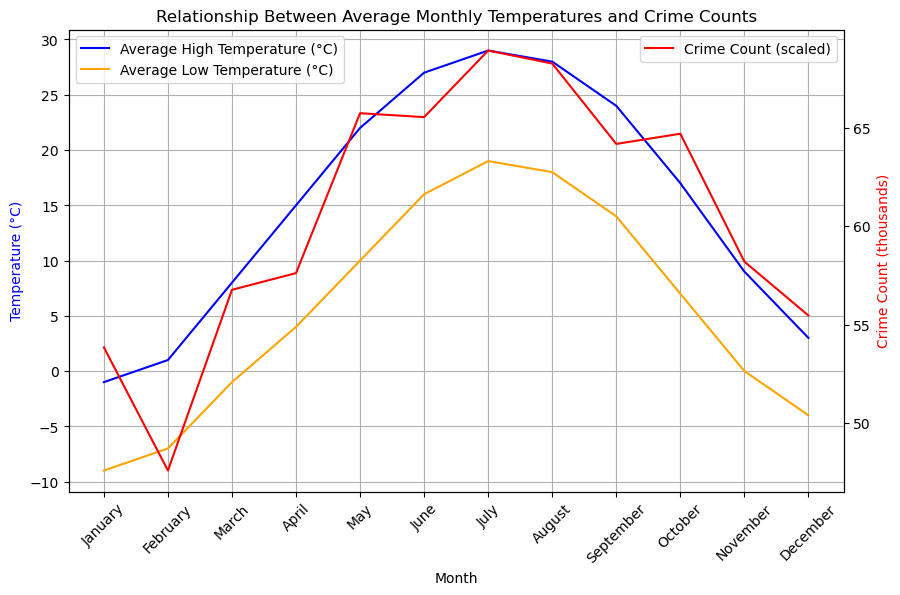

In [128]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average high temperature
ax1.plot(temp_avg['Month'], temp_avg['High_C'], label='Average High Temperature (°C)', color='blue')
ax1.plot(temp_avg['Month'], temp_avg['Low_C'], label='Average Low Temperature (°C)', color='orange')
ax1.set_xlabel('Month')
ax1.set_ylabel('Temperature (°C)', color='blue')

ax2 = ax1.twinx()
# Plot crime count
ax2.plot(month_chicago['Month'], month_chicago['Crime_Count (k)'], label='Crime Count (scaled)', color='red')
ax2.set_ylabel('Crime Count (thousands)', color='red')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_xticks(range(0, 12))
ax1.set_xticklabels(month_chicago['Month'], rotation=45)
plt.title('Relationship Between Average Monthly Temperatures and Crime Counts')
ax1.grid(True)

plt.show()

The graph above illustrates the average temperatures observed across the months from 2010 to 2019, also with the total counts of reported crimes spanning from 2002 to 2023, categorized by months. A notable observation is the apparent correlation between temperature fluctuations and the frequency of reported crimes. Throughout the analyzed period, it is discernible that crime occurrences peak during the warmer months, with July exhibiting the highest incidence, while February consistently records the lowest. Furthermore, the graph indicates a general trend of rising crime rates as temperatures ascend, which suggests that warmer weather tends to coincide with increased outdoor activities and greater social interaction. 

In [107]:
arrest_rate = chicago_crime_clean.pivot_table(index='Month', columns='Arrest', aggfunc='size', fill_value=0)
arrest_rate.columns = ['Arrested (False)', 'Arrested (True)']
arrest_rate['Arrest_Rate (%)'] = (arrest_rate['Arrested (True)'] / (arrest_rate['Arrested (False)'] + 
                                                                              arrest_rate['Arrested (True)'])) * 100
arrest_rate = arrest_rate.reset_index()

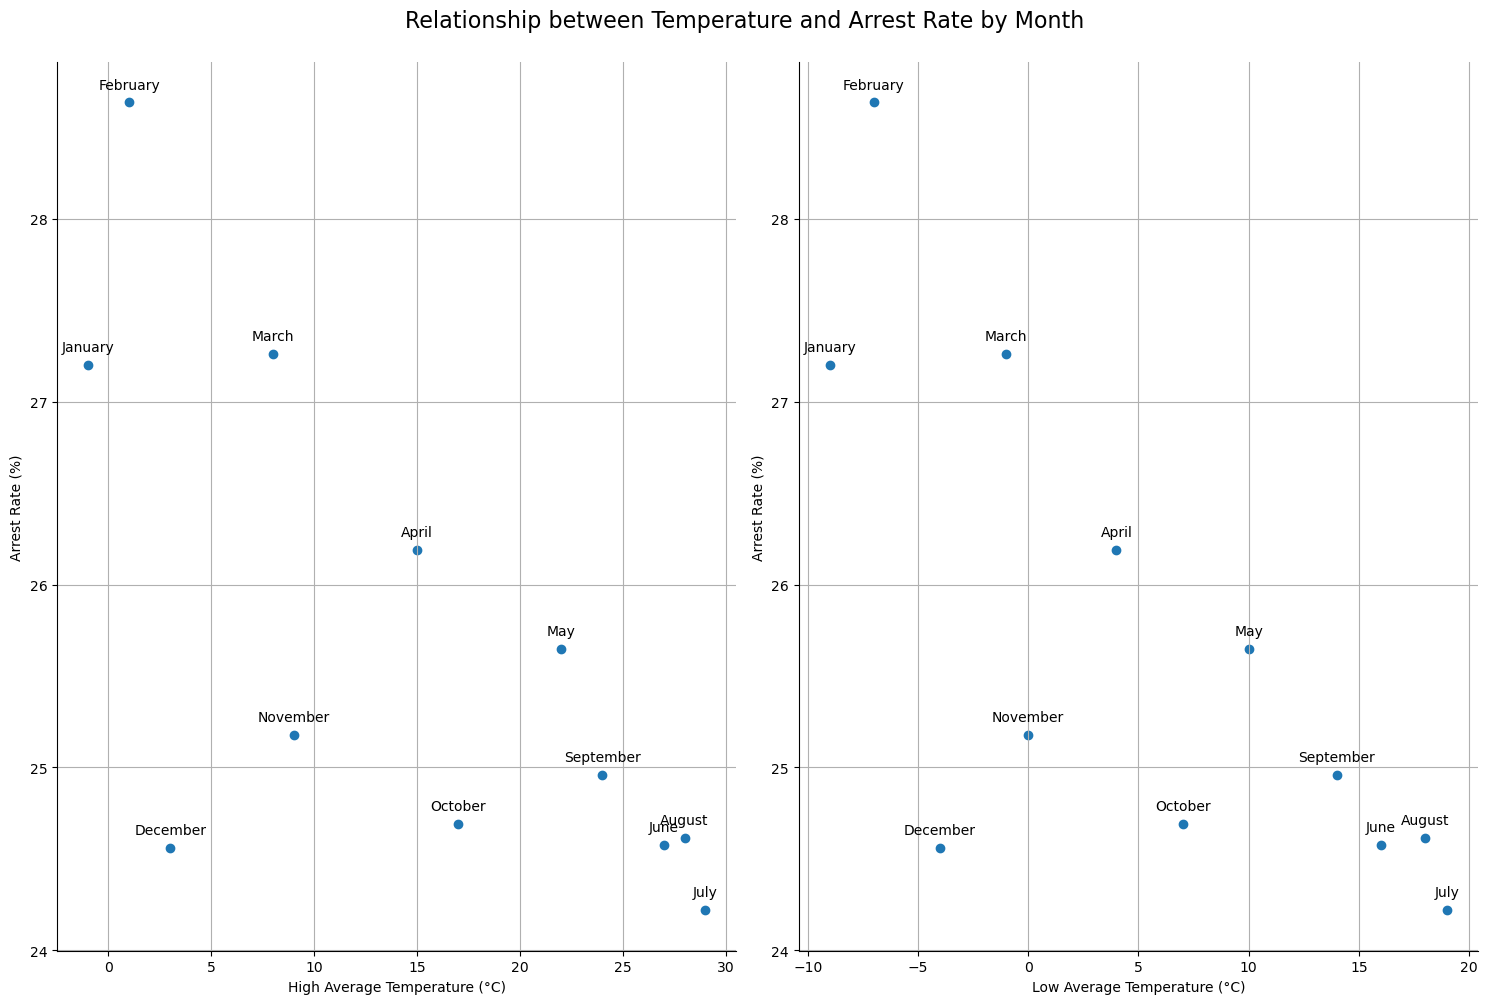

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

axes[0].scatter(temp_avg['High_C'], arrest_rate['Arrest_Rate (%)'])
axes[1].scatter(temp_avg['Low_C'], arrest_rate['Arrest_Rate (%)'])

axes[0].set_xlabel('High Average Temperature (°C)')
axes[1].set_xlabel('Low Average Temperature (°C)')
axes[0].set_ylabel('Arrest Rate (%)')
axes[1].set_ylabel('Arrest Rate (%)')
plt.suptitle('Relationship between Temperature and Arrest Rate by Month', fontsize=16, x=0.5, y=1)
axes[0].grid(True)
axes[1].grid(True)
for i, txt in enumerate(temp_avg['Month']):
    axes[0].annotate(txt, (temp_avg['High_C'].iloc[i], arrest_rate['Arrest_Rate (%)'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center')
    axes[1].annotate(txt, (temp_avg['Low_C'].iloc[i], arrest_rate['Arrest_Rate (%)'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
plt.show()

The scatter plot above illustrates the relationship between high and low average temperatures and the arrest rate. Interestingly, despite the observation that temperature has an impact on crime counts, it appears that the month itself plays a more influential role in determining the arrest rate. In February, despite relatively lower temperatures, the arrest rate surpasses 28%, whereas in July, despite higher temperatures, the arrest rate is only around 24%. This stark contrast is puzzling, especially considering the crime counts depicted in the previous analysis. July, typically associated with warmer weather, exhibits higher crime quantities, while February, often characterized by colder temperatures, showcases lower crime counts. This suggests that factors beyond temperature, such as socioeconomic conditions, law enforcement strategies, and community dynamics, may exert greater influence on arrest rates. Overall, while the temperature may play a role in shaping criminal behaviour, its impact on arrest rates appears to be mediated by multifaceted socio-economic and institutional factors. 

## 3.5 Adding a New Dataset

In this section, I am going to enrich the analysis by integrating a new dataset that provides insights into the racial composition of each community area in Chicago. We know that Chicago is a diverse city and there are many different races in the city, such as Black, White, Asian, and Latino. The sensitive subject here is that crime and arrest rates may differ by race, but I think it is worth researching in this project.

The dataset, sourced from the American Community Survey and obtained via the Chicago Health Atlas website, offers a comprehensive view of racial distribution across the city's community areas. By incorporating variables such as Non-Hispanic White, Non-Hispanic Black, Asian, Hispanic or Latino, Native American, Pacific Islander/Native Hawaiian, and Two or more races, we gain a nuanced understanding of the diverse population landscape within Chicago.

This integration is essential as it allows us to explore potential correlations between race and crime-related variables. While acknowledging the sensitivity of this subject, it is imperative to investigate whether disparities exist in crime rates and arrest outcomes across different racial groups. By examining these relationships, we can uncover underlying socioeconomic factors.

In [157]:
relative_path3 = os.path.join('..', 'Data', 'Chicago_race.csv')
abs_path3 = os.path.abspath(relative_path3)

# Read the CSV file
chicago_race = pd.read_csv(abs_path3)

In [158]:
chicago_race_clean = chicago_race.rename(columns={"PCT-W_2018-2022": "Non-Hispanic White (%)",
                                                  "PCT-B_2018-2022": "Non-Hispanic Black (%)",
                                                  "PCT-A_2018-2022": "Asian (%)", "PCT-H_2018-2022": "Hispanic or Latino (%)",
                                                  "PCT-P_2018-2022": "Native American (%)", "PCT-P1_2018-2022": "Native Hawaiian (%)",
                                                  "PCT-Q_2018-2022": "Two or more races (%)"})
chicago_race_clean.isnull().any(axis=0)

Layer                      True
Name                       True
GEOID                      True
Population                 True
Longitude                  True
Latitude                   True
Non-Hispanic White (%)    False
Non-Hispanic Black (%)    False
Asian (%)                 False
Hispanic or Latino (%)    False
Native American (%)       False
Native Hawaiian (%)       False
Two or more races (%)     False
dtype: bool

In [159]:
chicago_race_clean = chicago_race_clean.dropna()
chicago_race_clean.dtypes

Layer                      object
Name                       object
GEOID                     float64
Population                float64
Longitude                 float64
Latitude                  float64
Non-Hispanic White (%)     object
Non-Hispanic Black (%)     object
Asian (%)                  object
Hispanic or Latino (%)     object
Native American (%)        object
Native Hawaiian (%)        object
Two or more races (%)      object
dtype: object

In [160]:
# Change data type
chicago_race_clean['GEOID'] = chicago_race_clean['GEOID'].astype(int)
chicago_race_clean['Non-Hispanic White (%)'] = chicago_race_clean['Non-Hispanic White (%)'].astype(float)
chicago_race_clean['Non-Hispanic Black (%)'] = chicago_race_clean['Non-Hispanic Black (%)'].astype(float)
chicago_race_clean['Asian (%)'] = chicago_race_clean['Asian (%)'].astype(float)
chicago_race_clean['Hispanic or Latino (%)'] = chicago_race_clean['Hispanic or Latino (%)'].astype(float)
chicago_race_clean['Native American (%)'] = chicago_race_clean['Native American (%)'].astype(float)
chicago_race_clean['Native Hawaiian (%)'] = chicago_race_clean['Native Hawaiian (%)'].astype(float)
chicago_race_clean['Two or more races (%)'] = chicago_race_clean['Two or more races (%)'].astype(float)
# Combine the last three columns into one column
chicago_race_clean['Other Races (%)'] = chicago_race_clean.apply(lambda row: row['Native American (%)'] + 
                                                                 row['Native Hawaiian (%)'] + row['Two or more races (%)'], axis=1)
# Drop useless columns
chicago_race_clean = chicago_race_clean.drop(['Layer', 'Name', 'Native American (%)', 'Native Hawaiian (%)', 
                                              'Two or more races (%)'], axis=1)
# Keep three decimal
chicago_race_clean['Non-Hispanic White (%)'] = chicago_race_clean['Non-Hispanic White (%)'].round(3)
chicago_race_clean['Non-Hispanic Black (%)'] = chicago_race_clean['Non-Hispanic Black (%)'].round(3)
chicago_race_clean['Asian (%)'] = chicago_race_clean['Asian (%)'].round(3)
chicago_race_clean['Hispanic or Latino (%)'] = chicago_race_clean['Hispanic or Latino (%)'].round(3)
chicago_race_clean['Other Races (%)'] = chicago_race_clean['Other Races (%)'].round(3)

# Drop useless columns
chicago_race_clean = chicago_race_clean.drop(['Longitude', 'Latitude'], axis=1)

In [146]:
chicago_race_clean.describe()

,GEOID,Population,Non-Hispanic White (%),Non-Hispanic Black (%),Asian (%),Hispanic or Latino (%),Other Races (%)
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,39.000000,35570.857143,27.319208,36.457883,6.469766,26.964701,2.402714
std,22.371857,23354.909949,25.775990,37.990966,10.318573,27.318641,1.465437
min,1.000000,2514.000000,0.239000,0.035000,0.000000,0.519000,0.084000
25%,20.000000,18633.000000,4.253000,3.368000,0.560000,5.255000,1.215000
50%,39.000000,29899.000000,14.676000,13.929000,2.377000,14.835000,2.152000
75%,58.000000,45141.000000,46.676000,79.322000,9.274000,46.021000,3.518000
max,77.000000,103048.000000,83.973000,96.248000,64.643000,92.191000,5.900000


The table above shows statistical data about the new dataset. As we can see, in whole community areas of Chicago, the Black population is the largest since its mean is around 36.5%. Also, the average population of whites and Latinos is about the same, with 27.3% and 27% respectively. However, no matter which race, it seems like there exists one area where there is almost all people of that race and another area where there is almost no people of that race by looking for the max and min in the table.

In the next step, I will merge the data and plot some graphs to get a clear and deep observation.

In [248]:
chicago_race_clean_sorted = chicago_race_clean.sort_values(by='GEOID')
chicago_race_clean_sorted = chicago_race_clean_sorted.drop(['Population'],axis=1)
chicago_race_clean_sorted.set_index('GEOID', inplace=True)

In [242]:
crime_race_merge = pd.merge(merge, chicago_race_clean, left_on='Community Area', right_on='GEOID', how='left')
crime_race_merge = crime_race_merge.drop(['GEOID'],axis=1)

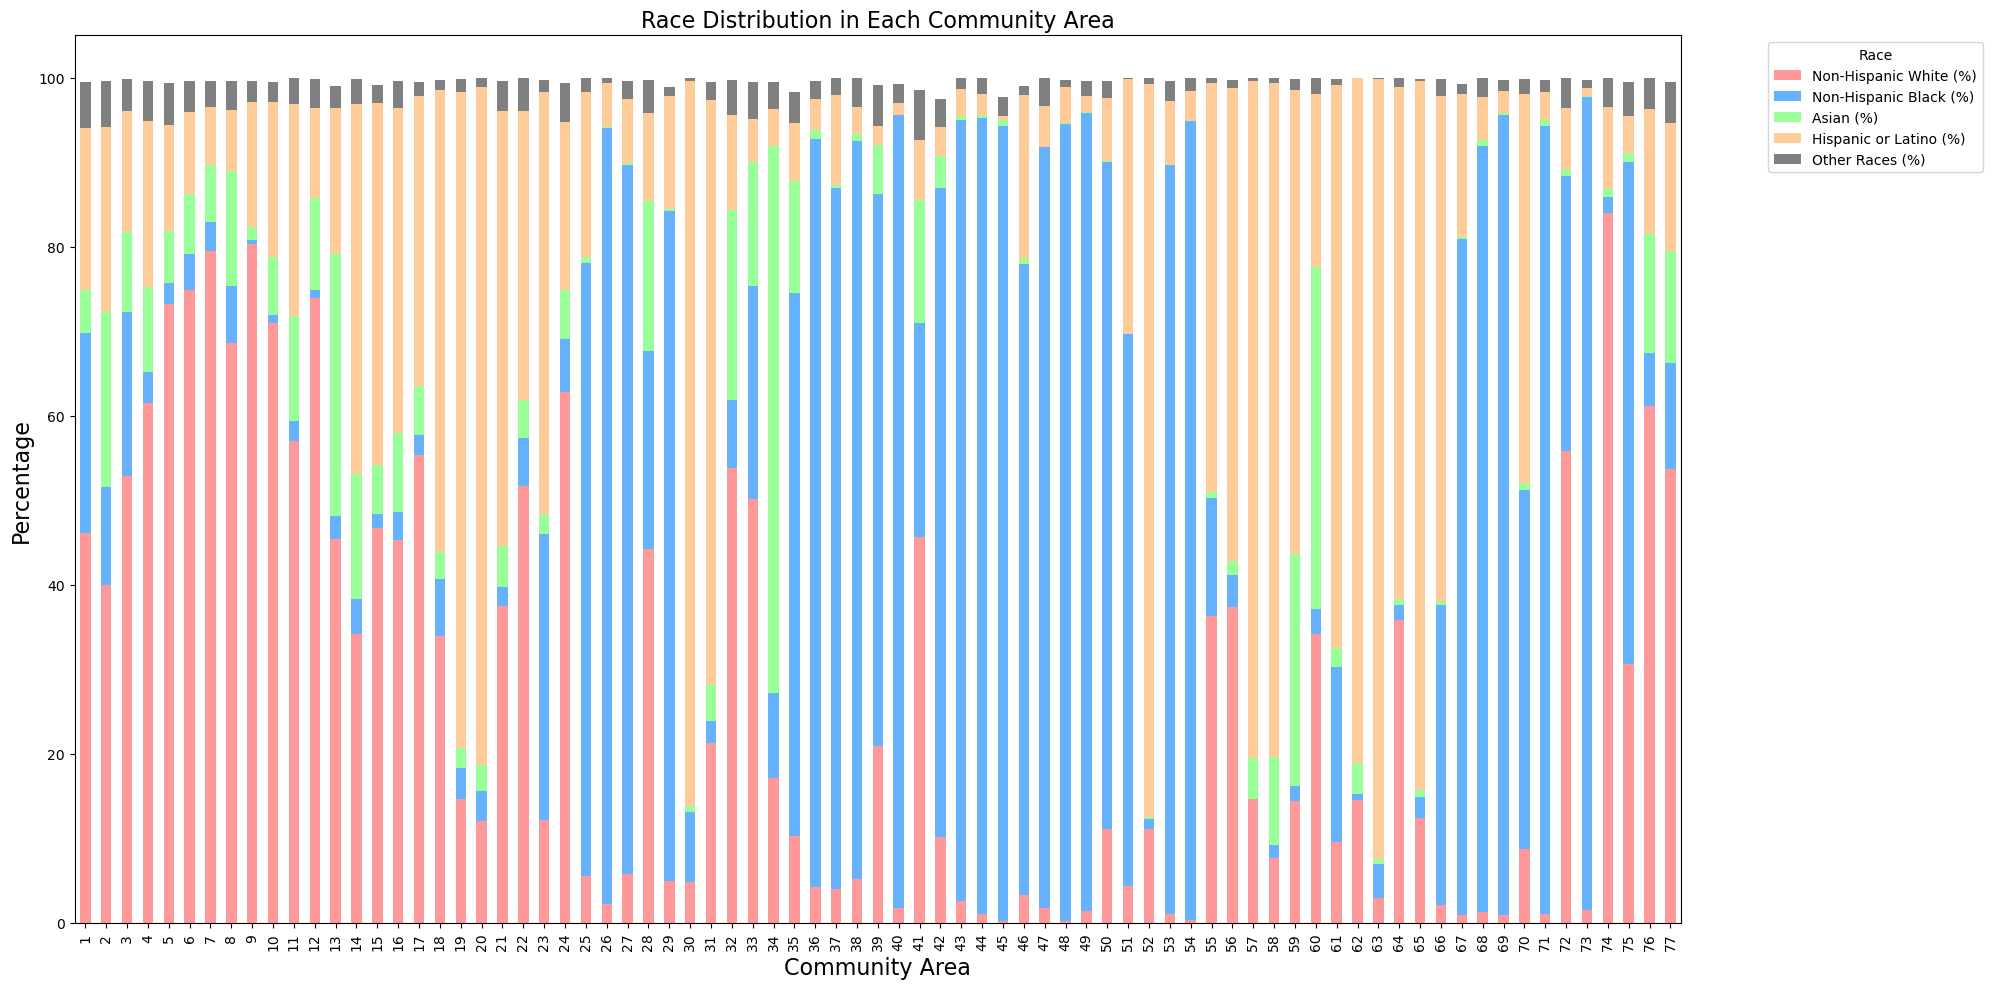

In [244]:
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', 'grey']
chicago_race_clean_sorted.plot(kind='bar', stacked=True, color=colors, figsize=(20,10))

plt.xlabel('Community Area', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.title('Race Distribution in Each Community Area', fontsize=16, x=0.5, y=1)
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(len(chicago_race_clean_sorted.index)), chicago_race_clean_sorted.index)
plt.tight_layout()
plt.show()

Based on the bar plot, we found that whites, blacks and Latinos are the three main races that make up Chicago, some areas are more Asian, like area 34 and area 60. Now, we could combine this graph and previous maps to see whether there exists some correlation between race and crime counts and arrest rates. Firstly, when looking at the "arrest rates" map, areas 26, 27, 25, 23, 29, 35, and 37 have relatively high arrest rates, and the above graph shows that these areas are predominantly black, except area 23, which has more Latinos. In addition, the map of the number of crimes in Chicago illustrates areas 26, 8, 43, and Central South have higher crime counts. After looking at this plot, we get a result that those areas are rarely predominantly white. Moreover, there is some correlation between per capita income and race proportion in one area. The areas that have higher per capita income are mostly white, and areas that have lower per capita income are mostly black, some are Latino.

Hence, taking these graphs together, we can indeed show that there is a relationship between the racial proportion of an area and the number of crimes, economy, and arrest rates. I will show arrest rates and the relationship between races to get a better understanding later.

In [260]:
crime_race_merge['Arrest Rate (%)'] = area_arrest['Percent_Arrested (True)']

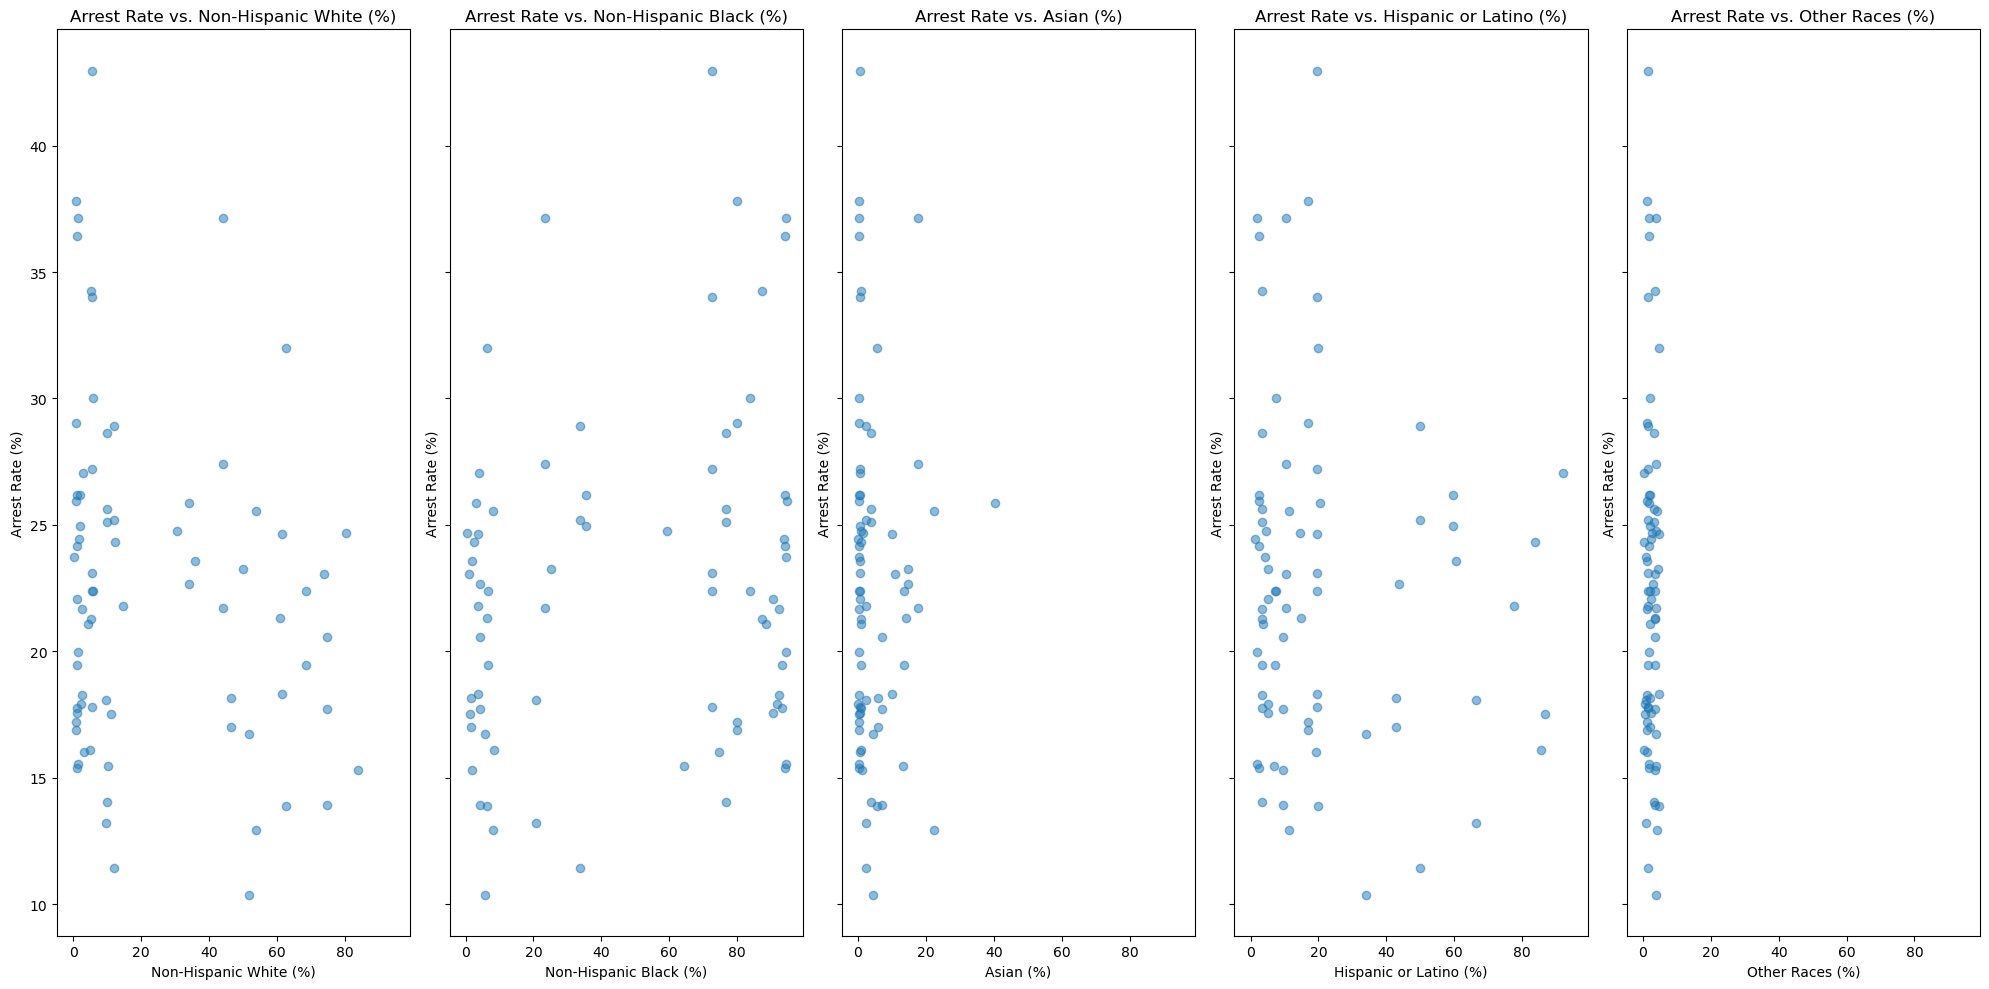

In [271]:
fig, axes = plt.subplots(1, 5, figsize=(20, 10), sharex=True, sharey=True)
race_columns = ['Non-Hispanic White (%)', 'Non-Hispanic Black (%)', 'Asian (%)', 'Hispanic or Latino (%)', 'Other Races (%)']

for i, race in enumerate(race_columns):
    ax = axes[i]
    ax.scatter(crime_race_merge[race], crime_race_merge['Arrest Rate (%)'], alpha=0.5)
    ax.set_xlabel(f'{race}')
    ax.set_ylabel('Arrest Rate (%)')
    ax.set_title(f'Arrest Rate vs. {race}')

plt.tight_layout()
plt.show()

To get a clearer and better observation, I plot the arrest rate with all kinds of races in 77 community areas. Here, we can easily see that in areas that are more than 60% white residents, their arrest rates are around or below 25%; and in areas that are more than 60% black residents display a broader range of arrest rates; also, for the fourth subplot, areas where have more than 60% Latino have arrest rates less than 30%. Since Asians and other races are a small percentage of all the areas, I do not focus too much on them. This analysis offers insights into race distribution in arrest rates across each community area.

## 3.6 Coclusion

In this research, I am trying to analyze whether crime types influence arrest rates in different community areas of Chicago from 2002 to 2023. With our statistical and visual analysis in Project 1, we see that over time, the number of crimes went down year by year and the arrest rate went down year by year. In addition, from the end analysis, we know that in 39 out of 77 regions, the most frequent type of crime was theft, but with our initial exploration, the number of people who were not arrested for theft was also the highest, even though it does not have the lowest arrest rate. Also, we found that the number of types of crime in an area affects the arrest rate in that area. Based on crime types, years, and community areas, the arrest rate has a large range with a minimum of 0% and a maximum of 100%. The average arrest rate is only around 19.3%, which implies in a significant portion of the data, arrests were made for approximately 19.3% of reported incidents. This indicates considerable variability in law enforcement outcomes across different crime types, years, and community areas.

In Project 2, I merge a per capita income new dataset and create maps to show the relationship between some variables and Chicago community areas. There are several areas in the upper middle West with higher arrest rates. Also, the north side of Chicago has lower arrest rates than the south side of Chicago. In addition, I show the difference in the number of crimes per area. In this map, I do not consider the population in each area so the results may be errors, but we could know that crime counts and arrest rates have some correlation. Moreover, I divide primary types into two groups, violent and non-violent crimes. As we can see, the number of non-violent crimes is greater than the number of violent overall. Lastly, I use the new dataset to show per capita income change over time. Several areas on the upper right of Chicago have the highest per capita incomes, while the west and south sides have relatively low incomes.

To have a deeper understanding, I scrape the average temperature data and observe that there is a positive correlation between crime and temperature. July has the highest number of crimes and February has the lowest. However, the arrest rates seem not influenced by temperature. On the opposite, February has the highest arrest rate, while July has the lowest. Furthermore, I merge a new dataset, racial distribution for each community area, and plot some graphs. Firstly, I found that whites, blacks and Latinos are the three main races in Chicago. Then, combined with Project 2, the areas with high arrest rates and low per capita incomes are mostly black and a small number predominantly Latino.

In conclusion, the data highlights the complexity and diversity of arrest outcomes in the context of crime types, years, and community areas. It becomes evident that arrest outcomes are influenced by a multitude of interconnected factors, including but not limited to crime types, temporal trends, socio-economic conditions, and racial demographics.

## References

1. Braga, A. A., Hureau, D. M., & Papachristos, A. V. (2011). The Relevance of Micro Places to Citywide Robbery Trends: A Longitudinal Analysis of Robbery Incidents at Street Corners and Block Faces in Boston. Journal of Research in Crime and Delinquency, 48(1), 7-32. https://doi.org/10.1177/0022427810384137

2. Erbe, B. M. (1975). Race and Socioeconomic Segregation. American Sociological Review, 40(6), 801–812. https://doi.org/10.2307/2094181

3. Hou, K., Zhang, L., Xu, X., Yang, F., Chen, B., Hu, W., & Shu, R. (2023). High ambient temperatures are associated with urban crime risk in Chicago. Science of The Total Environment, 856(1), 158846. https://doi.org/10.1016/j.scitotenv.2022.158846

4. Ousey, Graham C. (2000). “Explaining Regional and Urban Variation in Crime: A Review of Research.” Office of Justice Programs, https://www.ojp.gov/library/publications/explaining-regional-and-urban-variation-crime-review-research.

5. Schleiden, C., Soloski, K. L., Milstead, K., & Rhynehart, A. (2020). Racial disparities in arrests:  A Race Specific Model Explaining Arrest Rates Across Black and White Young Adults. Child Adolesc Soc Work Journal, 37, 1–14. https://link.springer.com/article/10.1007/s10560-019-00618-7#Abs1 

6. Wilson, W. J. (1987). The truly disadvantaged: The inner city, the underclass, and public policy. University of Chicago Press.